![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

# Clinical Named Entity Recognition (NER)

##  1. NER Model Implementation in Spark NLP

  The deep neural network architecture for NER model in
Spark NLP is BiLSTM-CNN-Char framework. a slightly modified version of the architecture proposed by Jason PC Chiu and Eric Nichols ([Named Entity Recognition with Bidirectional LSTM-CNNs
](https://arxiv.org/abs/1511.08308)). It is a neural network architecture that
automatically detects word and character-level features using a
hybrid bidirectional LSTM and CNN architecture, eliminating
the need for most feature engineering steps.

  In the original framework, the CNN extracts a fixed length
feature vector from character-level features. For each word,
these vectors are concatenated and fed to the BLSTM network
and then to the output layers. They employed a stacked
bi-directional recurrent neural network with long short-term
memory units to transform word features into named entity
tag scores. The extracted features of each word are fed into a
forward LSTM network and a backward LSTM network. The
output of each network at each time step is decoded by a linear
layer and a log-softmax layer into log-probabilities for each tag
category. These two vectors are then simply added together to
produce the final output. In the architecture of the proposed framework in the original paper, 50-dimensional pretrained word
embeddings is used for word features, 25-dimension character
embeddings is used for char features, and capitalization features
(allCaps, upperInitial, lowercase, mixedCaps, noinfo) are used
for case features.

## 2. Blogposts and videos:

- [How to Setup Spark NLP for HEALTHCARE on UBUNTU - Video](https://www.youtube.com/watch?v=yKnF-_oz0GE)

- [Named Entity Recognition (NER) with BERT in Spark NLP](https://towardsdatascience.com/named-entity-recognition-ner-with-bert-in-spark-nlp-874df20d1d77)

- [State of the art Clinical Named Entity Recognition in Spark NLP - Youtube](https://www.youtube.com/watch?v=YM-e4eOiQ34)

- [Named Entity Recognition for Healthcare with SparkNLP NerDL and NerCRF](https://medium.com/spark-nlp/named-entity-recognition-for-healthcare-with-sparknlp-nerdl-and-nercrf-a7751b6ad571)

- [Named Entity Recognition for Clinical Text](https://medium.com/atlas-research/ner-for-clinical-text-7c73caddd180)

## 3. Setup

In [ ]:
%pip install -q tensorflow==2.7.0
%pip install -q tensorflow-addons

     |████████████████████████████████| 665.5 MB 18 kB/s 
     |████████████████████████████████| 463 kB 5.3 MB/s 
     |████████████████████████████████| 1.3 MB 51.1 MB/s 
     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [ ]:
import json
import os

import nlu
import sparknlp
import sparknlp_jsl

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline,PipelineModel

import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

print("Spark NLP Version :", sparknlp.version())
print("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark = start_spark()
spark.sparkContext.setLogLevel("ERROR")

spark

Spark NLP Version : 4.1.0
Spark NLP_JSL Version : 4.1.0


## 4. Clinical NER Pipeline (with pretrained models)

- **Clinical NER Models**

|   index | model_name                     |   index | model_name                        |   index | model_name                        |   index | model_name                 |
|--------:|:-------------------------------|--------:|:----------------------------------|--------:|:----------------------------------|--------:|:---------------------------|
|       1 | jsl_ner_wip_clinical           |       2 | ner_chexpert                      |       3 | ner_deid_subentity (German)       |       4 | ner_jsl_greedy             |
|       5 | jsl_ner_wip_greedy_clinical    |       6 | ner_clinical                      |       7 | ner_diseases_large                |       8 | ner_jsl_slim               |
|       9 | jsl_ner_wip_modifier_clinical  |      10 | ner_clinical_icdem                |      11 | ner_drugs                         |      12 | ner_measurements_clinical  |
|      13 | jsl_rd_ner_wip_greedy_clinical |      14 | ner_clinical_large                |      15 | ner_drugs_greedy                  |      16 | ner_medmentions_coarse     |
|      17 | ner_ade_clinical               |      18 | ner_clinical_large_en             |      19 | ner_drugs_large                   |      20 | ner_posology               |
|      21 | ner_ade_clinicalbert           |      22 | ner_deid_augmented                |      23 | ner_events_admission_clinical     |      24 | ner_posology_experimental  |
|      25 | ner_ade_healthcare             |      26 | ner_deid_enriched                 |      27 | ner_events_clinical               |      28 | ner_posology_greedy        |
|      29 | ner_anatomy                    |      30 | ner_deid_generic_augmented        |      31 | ner_events_healthcare             |      32 | ner_posology_healthcare    |
|      33 | ner_anatomy_coarse             |      34 | ner_deid_generic (German)         |      35 | ner_genetic_variants              |      36 | ner_posology_large         |
|      37 | ner_bacterial_species          |      38 | ner_deid_large                    |      39 | ner_healthcare                    |      40 | ner_posology_small         |
|      41 | ner_bionlp                     |      42 | ner_deid_sd                       |      43 | ner_human_phenotype_gene_clinical |      44 | ner_profiling_clinical     |
|      45 | ner_cancer_genetics            |      46 | ner_deid_sd_large                 |      47 | ner_human_phenotype_go_clinical   |      48 | ner_radiology              |
|      49 | ner_cellular                   |      50 | ner_deid_subentity_augmented      |      51 | ner_jsl                           |      52 | ner_radiology_wip_clinical |
|      53 | ner_chemicals                  |      54 | ner_deid_synthetic                |      55 | ner_jsl_enriched                  |      56 | ner_risk_factors           |
|      57 | ner_chemprot_clinical          |      58 | ner_deidentify_dl                 |      59 | ner_nihss                         |      60 | ner_biomarker              |
|      61 | ner_abbreviation_clinical      |      62 | ner_deid_subentity_augmented_i2b2 |      63 | ner_diseases                      |      64 | ner_drugprot_clinical      |
|      65 | ner_nature_nero_clinical_en    |      66 | ner_supplement_clinical_en        |    67     | ner_biomedical_bc2gm           |         |                            |




- **BioBert NER Models**

|   index | model_name                    |   index | model_name                |   index | model_name                       |   index | model_name                 |
|--------:|:------------------------------|--------:|:--------------------------|--------:|:---------------------------------|--------:|:---------------------------|
|       1 | jsl_ner_wip_greedy_biobert    |       7 | ner_cellular_biobert      |      13 | ner_events_biobert               |      18 | ner_jsl_greedy_biobert     |
|       2 | jsl_rd_ner_wip_greedy_biobert |       8 | ner_chemprot_biobert      |      14 | ner_human_phenotype_gene_biobert |      19 | ner_posology_biobert       |
|       3 | ner_ade_biobert               |       9 | ner_clinical_biobert      |      15 | ner_human_phenotype_go_biobert   |      20 | ner_posology_large_biobert |
|       4 | ner_anatomy_biobert           |      10 | ner_deid_biobert          |      16 | ner_jsl_biobert                  |      21 | ner_profiling_biobert      |
|       5 | ner_anatomy_coarse_biobert    |      11 | ner_deid_enriched_biobert |      17 | ner_jsl_enriched_biobert         |      22 | ner_risk_factors_biobert   |
|       6 | ner_bionlp_biobert            |      12 | ner_diseases_biobert      |         |                                  |         |                            |


- **BertForTokenClassification Clinical NER models**

|    | model_name                         |
|---:|:-----------------------------------|
|  1 | bert_token_classifier_ner_ade      |
|  2 | bert_token_classifier_ner_clinical |
|  3 | bert_token_classifier_ner_deid     |
|  4 | bert_token_classifier_ner_drugs    |
|  5 | bert_token_classifier_ner_jsl      |
|  6 | bert_token_classifier_ner_jsl_slim |
|  7 | bert_token_classifier_ner_bionlp   |
|  8 | bert_token_classifier_ner_bacteria |
|  9 | bert_token_classifier_ner_anatomy  |
| 10 | bert_token_classifier_ner_cellular |
| 11 | bert_token_classifier_ner_chemprot |
| 12 | bert_token_classifier_ner_chemicals|
| 13 | bert_token_classifier_drug_development_trials   |



**You can find all these models and more [NLP Models Hub](https://nlp.johnsnowlabs.com/models?task=Named+Entity+Recognition&edition=Spark+NLP+for+Healthcare)**

**Also, you can print the list of clinical pretrained models/pipelines and annotators with one-line code:**

In [ ]:
from sparknlp_jsl.pretrained import InternalResourceDownloader

# pipelines = InternalResourceDownloader.returnPrivatePipelines()
ner_models = InternalResourceDownloader.returnPrivateModels("MedicalNerModel")
ner_models

[['nerdl_tumour_demo', 'en', '1.7.3'],
 ['nerdl_tumour_demo', 'en', '1.8.0'],
 ['nerdl_tumour_demo', 'en', '2.0.2'],
 ['ner_healthcare', 'en', '2.4.4'],
 ['ner_radiology', 'en', '2.7.0'],
 ['ner_deid_augmented', 'en', '2.7.1'],
 ['ner_deidentify_dl', 'en', '2.7.2'],
 ['ner_events_admission_clinical', 'en', '2.7.4'],
 ['ner_clinical', 'en', '3.0.0'],
 ['ner_radiology', 'en', '3.0.0'],
 ['ner_bionlp', 'en', '3.0.0'],
 ['ner_posology', 'en', '3.0.0'],
 ['ner_healthcare', 'de', '3.0.0'],
 ['ner_deid_augmented', 'en', '3.0.0'],
 ['ner_anatomy', 'en', '3.0.0'],
 ['ner_risk_factors', 'en', '3.0.0'],
 ['ner_chemprot_clinical', 'en', '3.0.0'],
 ['ner_posology_small', 'en', '3.0.0'],
 ['ner_diag_proc', 'es', '3.0.0'],
 ['ner_posology_greedy', 'en', '3.0.0'],
 ['ner_deid_enriched', 'en', '3.0.0'],
 ['ner_drugs_greedy', 'en', '3.0.0'],
 ['jsl_ner_wip_clinical', 'en', '3.0.0'],
 ['ner_posology_large', 'en', '3.0.0'],
 ['jsl_ner_wip_greedy_clinical', 'en', '3.0.0'],
 ['ner_clinical_large', 'en', '3.

In [ ]:
# Annotator that transforms a text column from dataframe into an Annotation ready for NLP
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
        
sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models")\
    .setInputCols(["document"])\
    .setOutputCol("sentence")
 
# Tokenizer splits words in a relevant format for NLP
tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

# Clinical word embeddings trained on PubMED dataset
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical","en","clinical/models")\
    .setInputCols(["sentence","token"])\
    .setOutputCol("embeddings")

# NER model trained on i2b2 (sampled from MIMIC) dataset
clinical_ner = MedicalNerModel.pretrained("ner_clinical_large","en","clinical/models")\
    .setInputCols(["sentence","token","embeddings"])\
    .setOutputCol("ner")\
    .setLabelCasing("upper") #decide if we want to return the tags in upper or lower case 

ner_converter = NerConverter()\
    .setInputCols(["sentence","token","ner"])\
    .setOutputCol("ner_chunk")

nlpPipeline = Pipeline(stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter])


empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)


sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical_large download started this may take some time.
[OK!]


In [ ]:
model.stages

[DocumentAssembler_eeeab2dd19a4,
 SentenceDetectorDLModel_6bafc4746ea5,
 REGEX_TOKENIZER_cdcff82a4adb,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 MedicalNerModel_1a8637089929,
 NerConverter_fc1de18e7a7c]

In [ ]:
clinical_ner.getClasses()

['O',
 'B-TREATMENT',
 'I-TREATMENT',
 'B-PROBLEM',
 'I-PROBLEM',
 'B-TEST',
 'I-TEST']

In [ ]:
clinical_ner.extractParamMap()

{Param(parent='MedicalNerModel_1a8637089929', name='includeAllConfidenceScores', doc='whether to include all confidence scores in annotation metadata or just the score of the predicted tag'): False,
 Param(parent='MedicalNerModel_1a8637089929', name='inferenceBatchSize', doc='number of sentences to process in a single batch during inference'): 1,
 Param(parent='MedicalNerModel_1a8637089929', name='labelCasing', doc='Setting all labels of the NER models upper/lower case. values upper|lower'): 'upper',
 Param(parent='MedicalNerModel_1a8637089929', name='lazyAnnotator', doc='Whether this AnnotatorModel acts as lazy in RecursivePipelines'): False,
 Param(parent='MedicalNerModel_1a8637089929', name='includeConfidence', doc='whether to include confidence scores in annotation metadata'): True,
 Param(parent='MedicalNerModel_1a8637089929', name='batchSize', doc='Size of every batch'): 64,
 Param(parent='MedicalNerModel_1a8637089929', name='classes', doc='get the tags used to trained this Medic

In [ ]:
clinical_ner.getStorageRef()

'clinical'

In [ ]:
from sparknlp_jsl.compatibility import Compatibility 
import pandas as pd

compatibility = Compatibility(spark)

models = compatibility.findVersion('ner') 

models_df = pd.DataFrame([dict(x) for x in list(models)])
models_df

name sparkVersion version language  \
0                nerdl_tumour_demo            2   1.7.3       en   
1               nercrf_tumour_demo            2   1.7.3       en   
2                nerdl_tumour_demo          2.4   1.8.0       en   
3               nercrf_tumour_demo          2.4   1.8.0       en   
4               nercrf_tumour_demo          2.4   2.0.2       en   
..                             ...          ...     ...      ...   
511          ner_profiling_biobert          3.0   4.0.2       en   
512          zero_shot_ner_roberta          3.0   4.0.2       en   
513         ner_profiling_clinical          3.0   4.0.2       en   
514               ner_model_finder          3.0   4.1.0       en   
515  sbertresolve_ner_model_finder          3.0   4.1.0       en   

                        date readyToUse  
0    2018-12-19T16:52:37.735       true  
1    2018-12-19T17:23:53.776       true  
2    2018-12-22T04:21:25.574       true  
3    2018-12-22T04:46:26.992       true  
4    2019-05-21T18:23:13.066       true  
..                       ...        ...  
511  2022-08-28T15:44:18.686       true  
512  2022-08-29T10:43:21.401       true  
513  2022-08-30T13:49:19.272       true  
514  2022-09-05T11:51:06.469       true  
515  2022-09-05T11:35:43.401       true  

[516 rows x 6 columns]

In [ ]:
# Downloading sample datasets.

! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/mt_samples.csv

In [ ]:
import pandas as pd

# mt_samples_df = spark.read.csv("mt_samples.csv", header=True)

mt_samples_df = spark.createDataFrame(pd.read_csv("./mt_samples.csv").reset_index())

In [ ]:
mt_samples_df.printSchema()

root
 |-- index: long (nullable = true)
 |-- text: string (nullable = true)



In [ ]:

mt_samples_df.show()

+-----+--------------------+
|index|                text|
+-----+--------------------+
|    0|Sample Type / Med...|
|    1|Sample Type / Med...|
|    2|Sample Type / Med...|
|    3|Sample Type / Med...|
|    4|Sample Type / Med...|
|    5|Sample Type / Med...|
|    6|Sample Type / Med...|
|    7|Sample Type / Med...|
|    8|Sample Type / Med...|
|    9|Sample Type / Med...|
|   10|Sample Type / Med...|
|   11|Sample Type / Med...|
|   12|Sample Type / Med...|
|   13|Sample Type / Med...|
|   14|Sample Type / Med...|
|   15|Sample Type / Med...|
|   16|Sample Type / Med...|
|   17|Sample Type / Med...|
|   18|Sample Type / Med...|
|   19|Sample Type / Med...|
+-----+--------------------+
only showing top 20 rows



In [ ]:
print(mt_samples_df.limit(1).collect()[0]['text'])

Sample Type / Medical Specialty:
Hematology - Oncology
Sample Name:
Discharge Summary - Mesothelioma - 1
Description:
Mesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.
(Medical Transcription Sample Report)
PRINCIPAL DIAGNOSIS:
Mesothelioma.
SECONDARY DIAGNOSES:
Pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.
PROCEDURES
1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural fluoroscopy.
2. On August 20, 2007, thoracentesis.
3. On August 31, 2007, Port-A-Cath placement.
HISTORY AND PHYSICAL:
The patient is a 41-year-old Vietnamese female with a nonproductive cough that started last week. She has had right-sided chest pain radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 and developed cough with right-sided chest pain, and went to an urgent care cen

In [ ]:
result = model.transform(mt_samples_df.limit(100)).cache()

In [ ]:
result.show()

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|index|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    0|Sample Type / Med...|[{document, 0, 54...|[{document, 0, 53...|[{token, 0, 5, Sa...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 118, 129...|
|    1|Sample Type / Med...|[{document, 0, 32...|[{document, 0, 53...|[{token, 0, 5, Sa...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 68, 92, ...|
|    2|Sample Type / Med...|[{document, 0, 42...|[{document, 0, 53...|[{token, 0, 5, Sa...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 68, 73, ...|
|    3|Sample Type / Med...|[{document, 0, 20...|[{document, 0, 53...|

In [ ]:
%%time

result.select('token.result','ner.result').show(truncate=100)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                              result|                                                                                              result|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|[Sample, Type, /, Medical, Specialty, :, Hematology, -, Oncology, Sample, Name, :, Discharge, Sum...|[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-PROBLEM, O, B-PROBLEM, I-PROBLEM, ...|
|[Sample, Type, /, Medical, Specialty, :, Hematology, -, Oncology, Sample, Name, :, BCCa, Excision...|[O, O, O, O, O, O, O, O, O, O, O, O, B-TREATMENT, I-TREATMENT, I-TREATMENT, I-TREA

In [ ]:
result_df = result.select(F.explode(F.arrays_zip(result.token.result,
                                                 result.ner.result, 
                                                 result.ner.metadata)).alias("cols"))\
                  .select(F.expr("cols['0']").alias("token"),
                          F.expr("cols['1']").alias("ner_label"),
                          F.expr("cols['2']['confidence']").alias("confidence"))

result_df.show(50, truncate=100)

+-------------+---------+----------+
|        token|ner_label|confidence|
+-------------+---------+----------+
|       Sample|        O|    0.9996|
|         Type|        O|    0.9921|
|            /|        O|    0.9717|
|      Medical|        O|    0.9824|
|    Specialty|        O|    0.9993|
|            :|        O|       1.0|
|   Hematology|        O|    0.9964|
|            -|        O|    0.9879|
|     Oncology|        O|    0.9718|
|       Sample|        O|    0.9999|
|         Name|        O|    0.9995|
|            :|        O|       1.0|
|    Discharge|        O|    0.9998|
|      Summary|        O|    0.9936|
|            -|        O|    0.9954|
| Mesothelioma|        O|    0.8738|
|            -|        O|    0.9773|
|            1|        O|     0.594|
|  Description|        O|    0.9995|
|            :|        O|    0.9999|
| Mesothelioma|B-PROBLEM|    0.9991|
|            ,|        O|    0.9999|
|      pleural|B-PROBLEM|    0.9912|
|     effusion|I-PROBLEM|    0.9982|
|

In [ ]:
result_df.select("token", "ner_label")\
         .groupBy('ner_label').count()\
         .orderBy('count', ascending=False)\
         .show(truncate=False)

+-----------+-----+
|ner_label  |count|
+-----------+-----+
|O          |25751|
|I-PROBLEM  |3139 |
|B-PROBLEM  |2141 |
|I-TREATMENT|1301 |
|B-TREATMENT|1254 |
|I-TEST     |918  |
|B-TEST     |792  |
+-----------+-----+



In [ ]:
result.select('ner_chunk').take(1)

[Row(ner_chunk=[Row(annotatorType='chunk', begin=118, end=129, result='Mesothelioma', metadata={'sentence': '2', 'chunk': '0', 'entity': 'PROBLEM', 'confidence': '0.9991'}, embeddings=[]), Row(annotatorType='chunk', begin=132, end=147, result='pleural effusion', metadata={'sentence': '2', 'chunk': '1', 'entity': 'PROBLEM', 'confidence': '0.99469995'}, embeddings=[]), Row(annotatorType='chunk', begin=150, end=168, result='atrial fibrillation', metadata={'sentence': '2', 'chunk': '2', 'entity': 'PROBLEM', 'confidence': '0.99785'}, embeddings=[]), Row(annotatorType='chunk', begin=171, end=176, result='anemia', metadata={'sentence': '2', 'chunk': '3', 'entity': 'PROBLEM', 'confidence': '0.999'}, embeddings=[]), Row(annotatorType='chunk', begin=179, end=185, result='ascites', metadata={'sentence': '2', 'chunk': '4', 'entity': 'PROBLEM', 'confidence': '0.9996'}, embeddings=[]), Row(annotatorType='chunk', begin=188, end=204, result='esophageal reflux', metadata={'sentence': '2', 'chunk': '5',

In [ ]:
result.select(F.explode(F.arrays_zip(result.ner_chunk.result, 
                                     result.ner_chunk.metadata)).alias("cols")) \
      .select(F.expr("cols['0']").alias("chunk"),
              F.expr("cols['1']['entity']").alias("ner_label"),
              F.expr("cols['1']['confidence']").alias("confidence")).show(truncate=False)

+-------------------------+---------+----------+
|chunk                    |ner_label|confidence|
+-------------------------+---------+----------+
|Mesothelioma             |PROBLEM  |0.9991    |
|pleural effusion         |PROBLEM  |0.99469995|
|atrial fibrillation      |PROBLEM  |0.99785   |
|anemia                   |PROBLEM  |0.999     |
|ascites                  |PROBLEM  |0.9996    |
|esophageal reflux        |PROBLEM  |0.9979    |
|deep venous thrombosis   |PROBLEM  |0.9684    |
|Mesothelioma             |PROBLEM  |0.987     |
|Pleural effusion         |PROBLEM  |0.97935   |
|atrial fibrillation      |PROBLEM  |0.99485004|
|anemia                   |PROBLEM  |0.9985    |
|ascites                  |PROBLEM  |0.9995    |
|esophageal reflux        |PROBLEM  |0.99724996|
|deep venous thrombosis   |PROBLEM  |0.9554667 |
|decortication of the lung|TREATMENT|0.749675  |
|pleural biopsy           |TEST     |0.87675   |
|transpleural fluoroscopy |TEST     |0.93474996|
|thoracentesis      

### with LightPipelines

In [ ]:
# fullAnnotate in LightPipeline

text = '''
A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis three years prior to presentation , and associated with an acute hepatitis , presented with a one-week history of polyuria , poor appetite , and vomiting . 
She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation . 
Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity . Pertinent laboratory findings on admission were : serum glucose 111 mg/dl ,  creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , and venous pH 7.27 . 
'''

print (text)

light_model = LightPipeline(model)

light_result = light_model.fullAnnotate(text)


chunks = []
entities = []
sentence= []
begin = []
end = []

for n in light_result[0]['ner_chunk']:
        
    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    sentence.append(n.metadata['sentence'])
    
    
import pandas as pd

df_clinical = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end, 
                   'sentence_id':sentence, 'entities':entities})

df_clinical.head(20)


A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis three years prior to presentation , and associated with an acute hepatitis , presented with a one-week history of polyuria , poor appetite , and vomiting . 
She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation . 
Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity . Pertinent laboratory findings on admission were : serum glucose 111 mg/dl ,  creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , and venous pH 7.27 . 



chunks  begin  end sentence_id   entities
0           gestational diabetes mellitus     40   68           0    PROBLEM
1   subsequent type two diabetes mellitus    118  154           0    PROBLEM
2                                    T2DM    158  161           0    PROBLEM
3                HTG-induced pancreatitis    187  210           0    PROBLEM
4                      an acute hepatitis    268  285           0    PROBLEM
5                                polyuria    326  333           0    PROBLEM
6                           poor appetite    337  349           0    PROBLEM
7                                vomiting    357  364           0    PROBLEM
8                               metformin    380  388           1  TREATMENT
9                               glipizide    392  400           1  TREATMENT
10                          dapagliflozin    408  420           1  TREATMENT
11                                   T2DM    426  429           1    PROBLEM
12                           atorvastatin    435  446           1  TREATMENT
13                            gemfibrozil    452  462           1  TREATMENT
14                                    HTG    468  470           1    PROBLEM
15                          dapagliflozin    490  502           2  TREATMENT
16                   Physical examination    550  569           3       TEST
17                        dry oral mucosa    607  621           3    PROBLEM
18              her abdominal examination    641  665           3       TEST
19                             tenderness    686  695           3    PROBLEM

In [ ]:
light_result[0]

{'document': [Annotation(document, 0, 901, 
  A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis three years prior to presentation , and associated with an acute hepatitis , presented with a one-week history of polyuria , poor appetite , and vomiting . 
  She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation . 
  Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity . Pertinent laboratory findings on admission were : serum glucose 111 mg/dl ,  creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , and venous pH 7.27 . 
  , {})],
 'ner_chunk': [Annotation(chunk, 40, 68

**Prettifying the results with NLU**

John Snow Labs' NLU is a Python library for applying state-of-the-art text mining, directly on any dataframe, with a single line of code. We will use some functionalities of NLU to prettify our results.

In [ ]:
nlu.to_pretty_df(model, text, positions=True, output_level='chunk').columns

Index(['index', 'document', 'document_begin', 'document_end',
       'entities_ner_chunk', 'entities_ner_chunk_begin',
       'entities_ner_chunk_class', 'entities_ner_chunk_confidence',
       'entities_ner_chunk_end', 'entities_ner_chunk_origin_chunk',
       'entities_ner_chunk_origin_sentence', 'ner_iob_ner_begin',
       'ner_iob_ner_end', 'sentence_dl', 'sentence_dl_begin',
       'sentence_dl_end', 'token_begin', 'token_end',
       'word_embedding_embeddings', 'word_embedding_embeddings_begin',
       'word_embedding_embeddings_end'],
      dtype='object')

In [ ]:
#For a given pipeline output level is automatically set to the last anntator's output level by default.
#This can be changed by defining the value of "output_level" parameter.
#Values can be set as; token, sentence, document, chunk and relation .

cols = [
     'entities_ner_chunk',
     'entities_ner_chunk_begin',
     'entities_ner_chunk_end',
     'entities_ner_chunk_origin_sentence',
     'entities_ner_chunk_class',
]
df_clinical = nlu.to_pretty_df(model, text, positions=True, output_level='chunk')[cols]
df_clinical.head(20)

entities_ner_chunk entities_ner_chunk_begin  \
0           gestational diabetes mellitus                       40   
1   subsequent type two diabetes mellitus                      118   
2                                    T2DM                      158   
3                HTG-induced pancreatitis                      187   
4                      an acute hepatitis                      268   
5                                polyuria                      326   
6                           poor appetite                      337   
7                                vomiting                      357   
8                               metformin                      380   
9                               glipizide                      392   
10                          dapagliflozin                      408   
11                                   T2DM                      426   
12                           atorvastatin                      435   
13                            gemfibrozil                      452   
14                                    HTG                      468   
15                          dapagliflozin                      490   
16                   Physical examination                      550   
17                        dry oral mucosa                      607   
18              her abdominal examination                      641   
19                             tenderness                      686   

   entities_ner_chunk_end entities_ner_chunk_origin_sentence  \
0                      68                                  0   
1                     154                                  0   
2                     161                                  0   
3                     210                                  0   
4                     285                                  0   
5                     333                                  0   
6                     349                                  0   
7                     364                                  0   
8                     388                                  1   
9                     400                                  1   
10                    420                                  1   
11                    429                                  1   
12                    446                                  1   
13                    462                                  1   
14                    470                                  1   
15                    502                                  2   
16                    569                                  3   
17                    621                                  3   
18                    665                                  3   
19                    695                                  3   

   entities_ner_chunk_class  
0                   PROBLEM  
1                   PROBLEM  
2                   PROBLEM  
3                   PROBLEM  
4                   PROBLEM  
5                   PROBLEM  
6                   PROBLEM  
7                   PROBLEM  
8                 TREATMENT  
9                 TREATMENT  
10                TREATMENT  
11                  PROBLEM  
12                TREATMENT  
13                TREATMENT  
14                  PROBLEM  
15                TREATMENT  
16                     TEST  
17                  PROBLEM  
18                     TEST  
19                  PROBLEM

### NER Visualizer

For saving the visualization result, provide `save_path` parameter in the display function.

In [ ]:
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

visualiser.display(light_result[0], label_col='ner_chunk', document_col='document', save_path="display_result.html")

# Change color of an entity label

#visualiser.set_label_colors({'PROBLEM':'#008080', 'TEST':'#800080', 'TREATMENT':'#808080'})
#visualiser.display(light_result[0], label_col='ner_chunk')

# Set label filter

# visualiser.display(light_result[0], label_col='ner_chunk', document_col='document',
                   #labels=['PROBLEM','TEST'])

## NER JSL
Let's show an example of `ner_jsl` model that has about 80 clinical entity labels by changing just only the model name.

**Entities**

| | | | | |
|-|-|-|-|-|
|Injury_or_Poisoning|Direction|Test|Admission_Discharge|Death_Entity|
|Relationship_Status|Duration|Respiration|Hyperlipidemia|Birth_Entity|
|Age|Labour_Delivery|Family_History_Header|BMI|Temperature|
|Alcohol|Kidney_Disease|Oncological|Medical_History_Header|Cerebrovascular_Disease|
|Oxygen_Therapy|O2_Saturation|Psychological_Condition|Heart_Disease|Employment|
|Obesity|Disease_Syndrome_Disorder|Pregnancy|ImagingFindings|Procedure|
|Medical_Device|Race_Ethnicity|Section_Header|Symptom|Treatment|
|Substance|Route|Drug_Ingredient|Blood_Pressure|Diet|
|External_body_part_or_region|LDL|VS_Finding|Allergen|EKG_Findings|
|Imaging_Technique|Triglycerides|RelativeTime|Gender|Pulse|
|Social_History_Header|Substance_Quantity|Diabetes|Modifier|Internal_organ_or_component|
|Clinical_Dept|Form|Drug_BrandName|Strength|Fetus_NewBorn|
|RelativeDate|Height|Test_Result|Sexually_Active_or_Sexual_Orientation|Frequency|
|Time|Weight|Vaccine|Vital_Signs_Header|Communicable_Disease|
|Dosage|Overweight|Hypertension|HDL|Total_Cholesterol|
|Smoking|Date||||

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence") 

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

jsl_ner = MedicalNerModel.pretrained("ner_jsl", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("jsl_ner")

jsl_ner_converter = NerConverter() \
    .setInputCols(["sentence", "token", "jsl_ner"]) \
    .setOutputCol("jsl_ner_chunk")

jsl_ner_pipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    jsl_ner,
    jsl_ner_converter])

empty_data = spark.createDataFrame([[""]]).toDF("text")

jsl_ner_model = jsl_ner_pipeline.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_jsl download started this may take some time.
[OK!]


In [ ]:
cols = [
     'entities_jsl_ner_chunk',
     'entities_jsl_ner_chunk_begin',
     'entities_jsl_ner_chunk_end',
     'entities_jsl_ner_chunk_origin_sentence',
     'entities_jsl_ner_chunk_class',
]
jsl_df = nlu.to_pretty_df(jsl_ner_model, text,positions=True, output_level='chunk')[cols]
jsl_df.head(20)

entities_jsl_ner_chunk entities_jsl_ner_chunk_begin  \
0                     28-year-old                            3   
1                          female                           15   
2   gestational diabetes mellitus                           40   
3               eight years prior                           80   
4                      subsequent                          118   
5      type two diabetes mellitus                          129   
6                            T2DM                          158   
7        HTG-induced pancreatitis                          187   
8               three years prior                          212   
9                           acute                          271   
10                      hepatitis                          277   
11                       one-week                          306   
12                       polyuria                          326   
13                  poor appetite                          337   
14                       vomiting                          357   
15                            She                          369   
16                      metformin                          380   
17                      glipizide                          392   
18                  dapagliflozin                          408   
19                           T2DM                          426   

   entities_jsl_ner_chunk_end entities_jsl_ner_chunk_origin_sentence  \
0                          13                                      0   
1                          20                                      0   
2                          68                                      0   
3                          96                                      0   
4                         127                                      0   
5                         154                                      0   
6                         161                                      0   
7                         210                                      0   
8                         228                                      0   
9                         275                                      0   
10                        285                                      0   
11                        313                                      0   
12                        333                                      0   
13                        349                                      0   
14                        364                                      0   
15                        371                                      1   
16                        388                                      1   
17                        400                                      1   
18                        420                                      1   
19                        429                                      1   

   entities_jsl_ner_chunk_class  
0                           Age  
1                        Gender  
2                      Diabetes  
3                  RelativeDate  
4                      Modifier  
5                      Diabetes  
6                      Diabetes  
7     Disease_Syndrome_Disorder  
8                  RelativeDate  
9                      Modifier  
10    Disease_Syndrome_Disorder  
11                     Duration  
12                      Symptom  
13                      Symptom  
14                      Symptom  
15                       Gender  
16              Drug_Ingredient  
17              Drug_Ingredient  
18              Drug_Ingredient  
19              Drug_Ingredient

In [ ]:
print (text)

jsl_light_model = LightPipeline(jsl_ner_model)

jsl_light_result = jsl_light_model.fullAnnotate(text)


chunks = []
entities = []
sentence= []
begin = []
end = []

for n in jsl_light_result[0]['jsl_ner_chunk']:
        
    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    sentence.append(n.metadata['sentence'])
    
    
import pandas as pd

jsl_df = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end, 
                   'sentence_id':sentence, 'entities':entities})

jsl_df.head(20)


A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis three years prior to presentation , and associated with an acute hepatitis , presented with a one-week history of polyuria , poor appetite , and vomiting . 
She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation . 
Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity . Pertinent laboratory findings on admission were : serum glucose 111 mg/dl ,  creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , and venous pH 7.27 . 



chunks  begin  end sentence_id  \
0                     28-year-old      3   13           0   
1                          female     15   20           0   
2   gestational diabetes mellitus     40   68           0   
3               eight years prior     80   96           0   
4                      subsequent    118  127           0   
5      type two diabetes mellitus    129  154           0   
6                            T2DM    158  161           0   
7        HTG-induced pancreatitis    187  210           0   
8               three years prior    212  228           0   
9                           acute    271  275           0   
10                      hepatitis    277  285           0   
11                       one-week    306  313           0   
12                       polyuria    326  333           0   
13                  poor appetite    337  349           0   
14                       vomiting    357  364           0   
15                            She    369  371           1   
16                      metformin    380  388           1   
17                      glipizide    392  400           1   
18                  dapagliflozin    408  420           1   
19                           T2DM    426  429           1   

                     entities  
0                         Age  
1                      Gender  
2                    Diabetes  
3                RelativeDate  
4                    Modifier  
5                    Diabetes  
6                    Diabetes  
7   Disease_Syndrome_Disorder  
8                RelativeDate  
9                    Modifier  
10  Disease_Syndrome_Disorder  
11                   Duration  
12                    Symptom  
13                    Symptom  
14                    Symptom  
15                     Gender  
16            Drug_Ingredient  
17            Drug_Ingredient  
18            Drug_Ingredient  
19            Drug_Ingredient

### Checking `ner_clinical_large` and `ner_jsl` results together



In [ ]:
display(df_clinical)
visualiser.display(light_result[0], label_col='ner_chunk', document_col='document')
display(jsl_df)
visualiser.display(jsl_light_result[0], label_col='jsl_ner_chunk', document_col='document')

entities_ner_chunk entities_ner_chunk_begin  \
0           gestational diabetes mellitus                       40   
1   subsequent type two diabetes mellitus                      118   
2                                    T2DM                      158   
3                HTG-induced pancreatitis                      187   
4                      an acute hepatitis                      268   
5                                polyuria                      326   
6                           poor appetite                      337   
7                                vomiting                      357   
8                               metformin                      380   
9                               glipizide                      392   
10                          dapagliflozin                      408   
11                                   T2DM                      426   
12                           atorvastatin                      435   
13                            gemfibrozil                      452   
14                                    HTG                      468   
15                          dapagliflozin                      490   
16                   Physical examination                      550   
17                        dry oral mucosa                      607   
18              her abdominal examination                      641   
19                             tenderness                      686   
20                               guarding                      699   
21                               rigidity                      713   
22                          serum glucose                      774   
23                             creatinine                      801   
24                          triglycerides                      824   
25                      total cholesterol                      850   
26                              venous pH                      884   

   entities_ner_chunk_end entities_ner_chunk_origin_sentence  \
0                      68                                  0   
1                     154                                  0   
2                     161                                  0   
3                     210                                  0   
4                     285                                  0   
5                     333                                  0   
6                     349                                  0   
7                     364                                  0   
8                     388                                  1   
9                     400                                  1   
10                    420                                  1   
11                    429                                  1   
12                    446                                  1   
13                    462                                  1   
14                    470                                  1   
15                    502                                  2   
16                    569                                  3   
17                    621                                  3   
18                    665                                  3   
19                    695                                  3   
20                    706                                  3   
21                    720                                  3   
22                    786                                  4   
23                    810                                  4   
24                    836                                  4   
25                    866                                  4   
26                    892                                  4   

   entities_ner_chunk_class  
0                   PROBLEM  
1                   PROBLEM  
2                   PROBLEM  
3                   PROBLEM  
4                   PROBLEM  
5                   PROBLEM  
6                   PROBLEM  
7                   PROBLEM  

entities_jsl_ner_chunk entities_jsl_ner_chunk_begin  \
0                     28-year-old                            3   
1                          female                           15   
2   gestational diabetes mellitus                           40   
3               eight years prior                           80   
4                      subsequent                          118   
5      type two diabetes mellitus                          129   
6                            T2DM                          158   
7        HTG-induced pancreatitis                          187   
8               three years prior                          212   
9                           acute                          271   
10                      hepatitis                          277   
11                       one-week                          306   
12                       polyuria                          326   
13                  poor appetite                          337   
14                       vomiting                          357   
15                            She                          369   
16                      metformin                          380   
17                      glipizide                          392   
18                  dapagliflozin                          408   
19                           T2DM                          426   
20                   atorvastatin                          435   
21                    gemfibrozil                          452   
22                            HTG                          468   
23                            She                          474   
24                  dapagliflozin                          490   
25                 for six months                          504   
26                dry oral mucosa                          607   
27                            her                          641   
28                      abdominal                          645   
29                     tenderness                          686   
30                       guarding                          699   
31                       rigidity                          713   
32                      admission                          757   
33                  serum glucose                          774   
34                      111 mg/dl                          788   
35                     creatinine                          801   
36                      0.4 mg/dL                          812   
37        triglycerides 508 mg/dL                          824   
38    total cholesterol 122 mg/dL                          850   
39                      venous pH                          884   
40                           7.27                          894   

   entities_jsl_ner_chunk_end entities_jsl_ner_chunk_origin_sentence  \
0                          13                                      0   
1                          20                                      0   
2                          68                                      0   
3                          96                                      0   
4                         127                                      0   
5                         154                                      0   
6                         161                                      0   
7                         210                                      0   
8                         228                                      0   
9                         275                                      0   
10                        285                                      0   
11                        313                                      0   
12                        333                                      0   
13                        349                                      0   
14                        364                                      0   
15                        371                                      1   
16            

## Posology NER
**Entities**

- DOSAGE
- DRUG
- DURATION
- FORM
- FREQUENCY
- ROUTE
- STRENGTH

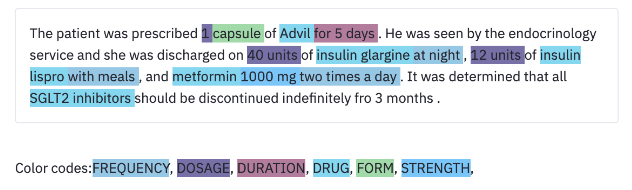

In [ ]:
# NER model trained on i2b2 (sampled from MIMIC) dataset
posology_ner = MedicalNerModel.pretrained("ner_posology", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

posology_ner_converter = NerConverter()\
    .setInputCols(["sentence","token","ner"])\
    .setOutputCol("ner_chunk")

# greedy model
posology_ner_greedy = MedicalNerModel.pretrained("ner_posology_greedy", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_greedy")

ner_converter_greedy = NerConverter()\
    .setInputCols(["sentence","token","ner_greedy"])\
    .setOutputCol("ner_chunk_greedy")

nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    posology_ner,
    posology_ner_converter,
    posology_ner_greedy,
    ner_converter_greedy])

empty_data = spark.createDataFrame([[""]]).toDF("text")

posology_model = nlpPipeline.fit(empty_data)


ner_posology download started this may take some time.
[OK!]
ner_posology_greedy download started this may take some time.
[OK!]


In [ ]:
posology_ner.getClasses()

['O',
 'B-DOSAGE',
 'B-STRENGTH',
 'I-STRENGTH',
 'B-ROUTE',
 'B-FREQUENCY',
 'I-FREQUENCY',
 'B-DRUG',
 'I-DRUG',
 'B-FORM',
 'I-DOSAGE',
 'B-DURATION',
 'I-DURATION',
 'I-FORM',
 'I-ROUTE']

In [ ]:
posology_result = posology_model.transform(mt_samples_df).cache()

In [ ]:
posology_result.show(10)

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|index|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|          ner_greedy|    ner_chunk_greedy|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    0|Sample Type / Med...|[{document, 0, 54...|[{document, 0, 53...|[{token, 0, 5, Sa...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 1609, 16...|[{named_entity, 0...|[{chunk, 1609, 16...|
|    1|Sample Type / Med...|[{document, 0, 32...|[{document, 0, 53...|[{token, 0, 5, Sa...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 742, 750...|[{named_entity, 0...|[{chunk, 742, 753...|
|    2|Sample T

In [ ]:
posology_result.printSchema()

root
 |-- index: long (nullable = true)
 |-- text: string (nullable = true)
 |-- document: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |    |    |-- embeddings: array (nullable = true)
 |    |    |    |-- element: float (containsNull = false)
 |-- sentence: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- valu

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id

# This will return a new DF with all the columns + id
posology_result = posology_result.withColumn("id", monotonically_increasing_id())

posology_result.show(3)

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---+
|index|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|          ner_greedy|    ner_chunk_greedy| id|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---+
|    0|Sample Type / Med...|[{document, 0, 54...|[{document, 0, 53...|[{token, 0, 5, Sa...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 1609, 16...|[{named_entity, 0...|[{chunk, 1609, 16...|  0|
|    1|Sample Type / Med...|[{document, 0, 32...|[{document, 0, 53...|[{token, 0, 5, Sa...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 742, 750...|[{named_entity, 0...|[{chunk, 742, 753...|

In [ ]:
posology_result.select('token.result','ner.result').show(truncate=100)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                              result|                                                                                              result|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|[Sample, Type, /, Medical, Specialty, :, Hematology, -, Oncology, Sample, Name, :, Discharge, Sum...|[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...|
|[Sample, Type, /, Medical, Specialty, :, Hematology, -, Oncology, Sample, Name, :, BCCa, Excision...|[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, 

In [ ]:
posology_result.select('token.result','ner.result').take(2)

[Row(result=['Sample', 'Type', '/', 'Medical', 'Specialty', ':', 'Hematology', '-', 'Oncology', 'Sample', 'Name', ':', 'Discharge', 'Summary', '-', 'Mesothelioma', '-', '1', 'Description', ':', 'Mesothelioma', ',', 'pleural', 'effusion', ',', 'atrial', 'fibrillation', ',', 'anemia', ',', 'ascites', ',', 'esophageal', 'reflux', ',', 'and', 'history', 'of', 'deep', 'venous', 'thrombosis', '.', '(', 'Medical', 'Transcription', 'Sample', 'Report', ')', 'PRINCIPAL', 'DIAGNOSIS', ':', 'Mesothelioma', '.', 'SECONDARY', 'DIAGNOSES', ':', 'Pleural', 'effusion', ',', 'atrial', 'fibrillation', ',', 'anemia', ',', 'ascites', ',', 'esophageal', 'reflux', ',', 'and', 'history', 'of', 'deep', 'venous', 'thrombosis', '.', 'PROCEDURES', '1', '.', 'On', 'August', '24', ',', '2007', ',', 'decortication', 'of', 'the', 'lung', 'with', 'pleural', 'biopsy', 'and', 'transpleural', 'fluoroscopy', '.', '2', '.', 'On', 'August', '20', ',', '2007', ',', 'thoracentesis', '.', '3', '.', 'On', 'August', '31', ',', '

In [ ]:
from pyspark.sql import functions as F

posology_result.select(F.explode(F.arrays_zip(posology_result.token.result, 
                                              posology_result.ner.result,
                                              posology_result.ner.metadata)).alias("cols")) \
               .select(F.expr("cols['0']").alias("token"),
                       F.expr("cols['1']").alias("ner_label"),
                       F.expr("cols['2']['confidence']").alias("confidence"))\
               .filter("ner_label!='O'")\
               .show(20, truncate=100)


+--------------+-----------+----------+
|         token|  ner_label|confidence|
+--------------+-----------+----------+
|      Coumadin|     B-DRUG|    0.9987|
|             1| B-STRENGTH|    0.8474|
|            mg| I-STRENGTH|    0.4713|
|         daily|B-FREQUENCY|    0.9999|
|    Amiodarone|     B-DRUG|    0.9993|
|           100| B-STRENGTH|    0.8387|
|            mg| I-STRENGTH|    0.4982|
|           p.o|    B-ROUTE|    0.9992|
|         daily|B-FREQUENCY|    0.9933|
|      Coumadin|     B-DRUG|    0.9904|
|       Lovenox|     B-DRUG|    0.7987|
|            40| B-STRENGTH|    0.5012|
|            mg| I-STRENGTH|    0.4837|
|subcutaneously|    B-ROUTE|    0.9825|
|  chemotherapy|     B-DRUG|    0.9984|
|     cisplatin|     B-DRUG|    0.9256|
|            75| B-STRENGTH|    0.9574|
| mg/centimeter| I-STRENGTH|    0.5491|
|           109| B-STRENGTH|    0.5696|
|            mg| I-STRENGTH|    0.6354|
+--------------+-----------+----------+
only showing top 20 rows



In [ ]:
posology_result.select('id',F.explode(F.arrays_zip(posology_result.ner_chunk.result, 
                                                   posology_result.ner_chunk.begin, 
                                                   posology_result.ner_chunk.end, 
                                                   posology_result.ner_chunk.metadata)).alias("cols")) \
               .select('id', F.expr("cols['3']['sentence']").alias("sentence_id"),
                       F.expr("cols['0']").alias("chunk"),
                       F.expr("cols['1']").alias("begin"),
                       F.expr("cols['2']").alias("end"),
                       F.expr("cols['3']['entity']").alias("ner_label"),
                       F.expr("cols['3']['confidence']").alias("confidence"))\
               .filter("ner_label!='O'")\
               .show(truncate=False)

+---+-----------+----------------+-----+----+---------+----------+
|id |sentence_id|chunk           |begin|end |ner_label|confidence|
+---+-----------+----------------+-----+----+---------+----------+
|0  |33         |Coumadin        |1609 |1616|DRUG     |0.9987    |
|0  |33         |1 mg            |1618 |1621|STRENGTH |0.65935004|
|0  |33         |daily           |1623 |1627|FREQUENCY|0.9999    |
|0  |34         |Amiodarone      |1696 |1705|DRUG     |0.9993    |
|0  |34         |100 mg          |1707 |1712|STRENGTH |0.66845   |
|0  |34         |p.o             |1714 |1716|ROUTE    |0.9992    |
|0  |34         |daily           |1719 |1723|FREQUENCY|0.9933    |
|0  |58         |Coumadin        |2770 |2777|DRUG     |0.9904    |
|0  |60         |Lovenox         |2880 |2886|DRUG     |0.7987    |
|0  |60         |40 mg           |2888 |2892|STRENGTH |0.49245   |
|0  |60         |subcutaneously  |2894 |2907|ROUTE    |0.9825    |
|0  |72         |chemotherapy    |4436 |4447|DRUG     |0.9984 

In [ ]:
posology_result.select('id',F.explode(F.arrays_zip(posology_result.ner_chunk_greedy.result, 
                                                   posology_result.ner_chunk_greedy.begin, 
                                                   posology_result.ner_chunk_greedy.end, 
                                                   posology_result.ner_chunk_greedy.metadata)).alias("cols")) \
               .select('id', F.expr("cols['3']['sentence']").alias("sentence_id"),
                        F.expr("cols['0']").alias("chunk"),
                        F.expr("cols['1']").alias("begin"),
                        F.expr("cols['2']").alias("end"),
                        F.expr("cols['3']['entity']").alias("ner_label"),
                        F.expr("cols['3']['confidence']").alias("confidence"))\
                .filter("ner_label!='O'")\
                .show(truncate=False)

+---+-----------+--------------------------------------------------------------+-----+----+---------+----------+
|id |sentence_id|chunk                                                         |begin|end |ner_label|confidence|
+---+-----------+--------------------------------------------------------------+-----+----+---------+----------+
|0  |33         |Coumadin 1 mg                                                 |1609 |1621|DRUG     |0.62009996|
|0  |33         |daily                                                         |1623 |1627|FREQUENCY|0.9962    |
|0  |34         |Amiodarone 100 mg p.o                                         |1696 |1716|DRUG     |0.6328    |
|0  |34         |daily                                                         |1719 |1723|FREQUENCY|0.8823    |
|0  |58         |Coumadin                                                      |2770 |2777|DRUG     |0.9863    |
|0  |72         |chemotherapy                                                  |4436 |4447|DRUG 

In [ ]:
posology_result.select('ner_chunk').take(2)[1][0][0].result

'Xylocaine'

In [ ]:
posology_result.select('ner_chunk').take(2)[1][0][0].metadata

{'sentence': '11', 'chunk': '0', 'entity': 'DRUG', 'confidence': '0.9903'}

In [ ]:
posology_light_model = LightPipeline(posology_model)

text ='The patient was prescribed 1 capsule of Advil for 5 days . He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely for 3 months .'

posology_light_result = posology_light_model.annotate(text)

list(zip(posology_light_result['token'], posology_light_result['ner']))

[('The', 'O'),
 ('patient', 'O'),
 ('was', 'O'),
 ('prescribed', 'O'),
 ('1', 'B-DOSAGE'),
 ('capsule', 'B-FORM'),
 ('of', 'O'),
 ('Advil', 'B-DRUG'),
 ('for', 'B-DURATION'),
 ('5', 'I-DURATION'),
 ('days', 'I-DURATION'),
 ('.', 'O'),
 ('He', 'O'),
 ('was', 'O'),
 ('seen', 'O'),
 ('by', 'O'),
 ('the', 'O'),
 ('endocrinology', 'O'),
 ('service', 'O'),
 ('and', 'O'),
 ('she', 'O'),
 ('was', 'O'),
 ('discharged', 'O'),
 ('on', 'O'),
 ('40', 'B-DOSAGE'),
 ('units', 'I-DOSAGE'),
 ('of', 'O'),
 ('insulin', 'B-DRUG'),
 ('glargine', 'I-DRUG'),
 ('at', 'B-FREQUENCY'),
 ('night', 'I-FREQUENCY'),
 (',', 'O'),
 ('12', 'B-DOSAGE'),
 ('units', 'I-DOSAGE'),
 ('of', 'O'),
 ('insulin', 'B-DRUG'),
 ('lispro', 'I-DRUG'),
 ('with', 'B-FREQUENCY'),
 ('meals', 'I-FREQUENCY'),
 (',', 'O'),
 ('and', 'O'),
 ('metformin', 'B-DRUG'),
 ('1000', 'B-STRENGTH'),
 ('mg', 'I-STRENGTH'),
 ('two', 'B-FREQUENCY'),
 ('times', 'I-FREQUENCY'),
 ('a', 'I-FREQUENCY'),
 ('day', 'I-FREQUENCY'),
 ('.', 'O'),
 ('It', 'O'),
 ('was

In [ ]:
list(zip(posology_light_result['token'], posology_light_result['ner_greedy']))

[('The', 'O'),
 ('patient', 'O'),
 ('was', 'O'),
 ('prescribed', 'O'),
 ('1', 'B-DRUG'),
 ('capsule', 'I-DRUG'),
 ('of', 'I-DRUG'),
 ('Advil', 'I-DRUG'),
 ('for', 'B-DURATION'),
 ('5', 'I-DURATION'),
 ('days', 'I-DURATION'),
 ('.', 'O'),
 ('He', 'O'),
 ('was', 'O'),
 ('seen', 'O'),
 ('by', 'O'),
 ('the', 'O'),
 ('endocrinology', 'O'),
 ('service', 'O'),
 ('and', 'O'),
 ('she', 'O'),
 ('was', 'O'),
 ('discharged', 'O'),
 ('on', 'O'),
 ('40', 'B-DRUG'),
 ('units', 'I-DRUG'),
 ('of', 'I-DRUG'),
 ('insulin', 'I-DRUG'),
 ('glargine', 'I-DRUG'),
 ('at', 'B-FREQUENCY'),
 ('night', 'I-FREQUENCY'),
 (',', 'O'),
 ('12', 'B-DRUG'),
 ('units', 'I-DRUG'),
 ('of', 'I-DRUG'),
 ('insulin', 'I-DRUG'),
 ('lispro', 'I-DRUG'),
 ('with', 'B-FREQUENCY'),
 ('meals', 'I-FREQUENCY'),
 (',', 'O'),
 ('and', 'O'),
 ('metformin', 'B-DRUG'),
 ('1000', 'I-DRUG'),
 ('mg', 'I-DRUG'),
 ('two', 'B-FREQUENCY'),
 ('times', 'I-FREQUENCY'),
 ('a', 'I-FREQUENCY'),
 ('day', 'I-FREQUENCY'),
 ('.', 'O'),
 ('It', 'O'),
 ('was', 

In [ ]:
posology_light_result = posology_light_model.fullAnnotate(text)

chunks = []
entities = []
begin =[]
end = []

for n in posology_light_result[0]['ner_chunk']:
        
    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    
import pandas as pd

posology_result_df = pd.DataFrame({'chunks':chunks, 'entities':entities,
                                   'begin': begin, 'end': end})

posology_result_df.head(15)

chunks   entities  begin  end
0                  1     DOSAGE     27   27
1            capsule       FORM     29   35
2              Advil       DRUG     40   44
3         for 5 days   DURATION     46   55
4           40 units     DOSAGE    126  133
5   insulin glargine       DRUG    138  153
6           at night  FREQUENCY    155  162
7           12 units     DOSAGE    166  173
8     insulin lispro       DRUG    178  191
9         with meals  FREQUENCY    193  202
10         metformin       DRUG    210  218
11           1000 mg   STRENGTH    220  226
12   two times a day  FREQUENCY    228  242
13  SGLT2 inhibitors       DRUG    273  288
14      for 3 months   DURATION    326  337

In [ ]:
cols = [
     'entities_ner_chunk',
     'entities_ner_chunk_class',
     'entities_ner_chunk_begin',
     'entities_ner_chunk_end',
]
posology_result_df = nlu.to_pretty_df(posology_light_model, text, positions=True, output_level='chunk')[cols]
posology_result_df.head(20)

entities_ner_chunk entities_ner_chunk_class entities_ner_chunk_begin  \
0                   1                   DOSAGE                       27   
1             capsule                     FORM                       29   
2               Advil                     DRUG                       40   
3          for 5 days                 DURATION                       46   
4            40 units                   DOSAGE                      126   
5    insulin glargine                     DRUG                      138   
6            at night                FREQUENCY                      155   
7            12 units                   DOSAGE                      166   
8      insulin lispro                     DRUG                      178   
9          with meals                FREQUENCY                      193   
10          metformin                     DRUG                      210   
11            1000 mg                 STRENGTH                      220   
12    two times a day                FREQUENCY                      228   
13   SGLT2 inhibitors                     DRUG                      273   
14       for 3 months                 DURATION                      326   

   entities_ner_chunk_end  
0                      27  
1                      35  
2                      44  
3                      55  
4                     133  
5                     153  
6                     162  
7                     173  
8                     191  
9                     202  
10                    218  
11                    226  
12                    242  
13                    288  
14                    337

In [ ]:
chunks = []
entities = []
begin =[]
end = []

for n in posology_light_result[0]['ner_chunk_greedy']:
        
    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    
import pandas as pd

posology_result_greedy_df = pd.DataFrame({'chunks':chunks, 
                                          'entities':entities,
                                          'begin': begin, 
                                          'end': end})

posology_result_greedy_df.head(15)

chunks   entities  begin  end
0            1 capsule of Advil       DRUG     27   44
1                    for 5 days   DURATION     46   55
2  40 units of insulin glargine       DRUG    126  153
3                      at night  FREQUENCY    155  162
4    12 units of insulin lispro       DRUG    166  191
5                    with meals  FREQUENCY    193  202
6             metformin 1000 mg       DRUG    210  226
7               two times a day  FREQUENCY    228  242
8              SGLT2 inhibitors       DRUG    273  288
9                  for 3 months   DURATION    326  337

In [ ]:
cols = [
     'entities_ner_chunk_greedy',
     'entities_ner_chunk_greedy_class',
     'entities_ner_chunk_greedy_begin',
     'entities_ner_chunk_greedy_end',
]
posology_result_greedy_df = nlu.to_pretty_df(posology_light_model, text, positions=True, output_level='chunk')[cols]
posology_result_greedy_df.head(10)

entities_ner_chunk_greedy entities_ner_chunk_greedy_class  \
0            1 capsule of Advil                            DRUG   
1                    for 5 days                        DURATION   
2  40 units of insulin glargine                            DRUG   
3                      at night                       FREQUENCY   
4    12 units of insulin lispro                            DRUG   
5                    with meals                       FREQUENCY   
6             metformin 1000 mg                            DRUG   
7               two times a day                       FREQUENCY   
8              SGLT2 inhibitors                            DRUG   
9                  for 3 months                        DURATION   

  entities_ner_chunk_greedy_begin entities_ner_chunk_greedy_end  
0                              27                            44  
1                              46                            55  
2                             126                           153  
3                             155                           162  
4                             166                           191  
5                             193                           202  
6                             210                           226  
7                             228                           242  
8                             273                           288  
9                             326                           337

### Comparison of `ner_posology` and `ner_posology_greedy` results

In [ ]:
display(posology_result_df.head(10))
visualiser.display(posology_light_result[0], label_col='ner_chunk', document_col='document')
display(posology_result_greedy_df.head(10))
visualiser.display(posology_light_result[0], label_col='ner_chunk_greedy', document_col='document')

entities_ner_chunk entities_ner_chunk_class entities_ner_chunk_begin  \
0                  1                   DOSAGE                       27   
1            capsule                     FORM                       29   
2              Advil                     DRUG                       40   
3         for 5 days                 DURATION                       46   
4           40 units                   DOSAGE                      126   
5   insulin glargine                     DRUG                      138   
6           at night                FREQUENCY                      155   
7           12 units                   DOSAGE                      166   
8     insulin lispro                     DRUG                      178   
9         with meals                FREQUENCY                      193   

  entities_ner_chunk_end  
0                     27  
1                     35  
2                     44  
3                     55  
4                    133  
5                    153  
6                    162  
7                    173  
8                    191  
9                    202

entities_ner_chunk_greedy entities_ner_chunk_greedy_class  \
0            1 capsule of Advil                            DRUG   
1                    for 5 days                        DURATION   
2  40 units of insulin glargine                            DRUG   
3                      at night                       FREQUENCY   
4    12 units of insulin lispro                            DRUG   
5                    with meals                       FREQUENCY   
6             metformin 1000 mg                            DRUG   
7               two times a day                       FREQUENCY   
8              SGLT2 inhibitors                            DRUG   
9                  for 3 months                        DURATION   

  entities_ner_chunk_greedy_begin entities_ner_chunk_greedy_end  
0                              27                            44  
1                              46                            55  
2                             126                           153  
3                             155                           162  
4                             166                           191  
5                             193                           202  
6                             210                           226  
7                             228                           242  
8                             273                           288  
9                             326                           337

## Writing a generic NER function

**Generic NER Function with LightPipeline**

In [ ]:
def get_light_model (embeddings, model_name = 'ner_clinical'):

  documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("document")

  sentenceDetector = SentenceDetector()\
      .setInputCols(["document"])\
      .setOutputCol("sentence")

  tokenizer = Tokenizer()\
      .setInputCols(["sentence"])\
      .setOutputCol("token")

  word_embeddings = WordEmbeddingsModel.pretrained(embeddings, "en", "clinical/models")\
      .setInputCols(["sentence", "token"])\
      .setOutputCol("embeddings")

  loaded_ner_model = MedicalNerModel.pretrained(model_name, "en", "clinical/models") \
      .setInputCols(["sentence", "token", "embeddings"]) \
      .setOutputCol("ner")

  ner_converter = NerConverter() \
      .setInputCols(["sentence", "token", "ner"]) \
      .setOutputCol("ner_chunk")

  nlpPipeline = Pipeline(stages=[
      documentAssembler,
      sentenceDetector,
      tokenizer,
      word_embeddings,
      loaded_ner_model,
      ner_converter])

  model = nlpPipeline.fit(spark.createDataFrame([[""]]).toDF("text"))

  return LightPipeline(model)

**Get NER Results with fullAnnotate Method**

In [ ]:
import pandas as pd

def get_light_result (light_model, text, chunk_name="ner_chunk"):

  light_result = light_model.fullAnnotate(text)

  chunks = []
  entities = []
  sentence= []
  begin = []
  end = []

  for n in light_result[0][chunk_name]:
                  
    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    sentence.append(n.metadata['sentence']) 
      
    pd_df = pd.DataFrame({'sentence_id':sentence, 
                          'begin': begin, 
                          'end':end, 
                          'chunks':chunks,  
                          'entities':entities})
  return pd_df

In [ ]:
embeddings = 'embeddings_clinical'

model_name = 'ner_clinical'

light_model = get_light_model (embeddings, model_name)

text = "I had a headache yesterday and took an Advil."

light_model.annotate(text)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical download started this may take some time.
[OK!]


{'document': ['I had a headache yesterday and took an Advil.'],
 'ner_chunk': ['a headache', 'an Advil'],
 'token': ['I',
  'had',
  'a',
  'headache',
  'yesterday',
  'and',
  'took',
  'an',
  'Advil',
  '.'],
 'ner': ['O',
  'O',
  'B-PROBLEM',
  'I-PROBLEM',
  'O',
  'O',
  'O',
  'B-TREATMENT',
  'I-TREATMENT',
  'O'],
 'embeddings': ['I',
  'had',
  'a',
  'headache',
  'yesterday',
  'and',
  'took',
  'an',
  'Advil',
  '.'],
 'sentence': ['I had a headache yesterday and took an Advil.']}

In [ ]:
get_light_result(light_model, text, chunk_name="ner_chunk")

sentence_id  begin  end      chunks   entities
0           0      6   15  a headache    PROBLEM
1           0     36   43    an Advil  TREATMENT

In [ ]:
cols = [
     'entities_ner_chunk_origin_sentence',
     'entities_ner_chunk_begin',
     'entities_ner_chunk_end',
     'entities_ner_chunk',
     'entities_ner_chunk_class',
]

nlu.to_pretty_df(light_model, text, positions=True, output_level='chunk')[cols]

entities_ner_chunk_origin_sentence entities_ner_chunk_begin  \
0                                  0                        6   
1                                  0                       36   

  entities_ner_chunk_end entities_ner_chunk entities_ner_chunk_class  
0                     15         a headache                  PROBLEM  
1                     43           an Advil                TREATMENT

In [ ]:
text ='''The patient was prescribed 1 capsule of Parol with meals . 
He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . 
It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months .'''

embeddings = 'embeddings_clinical'

model_name = 'ner_posology'

light_model = get_light_model (embeddings, model_name)

get_light_result (light_model, text, chunk_name="ner_chunk")

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_posology download started this may take some time.
[OK!]


sentence_id  begin  end            chunks   entities
0            0     27   27                 1     DOSAGE
1            0     29   35           capsule       FORM
2            0     40   44             Parol       DRUG
3            0     46   55        with meals  FREQUENCY
4            1    127  134          40 units     DOSAGE
5            1    139  154  insulin glargine       DRUG
6            1    156  163          at night  FREQUENCY
7            1    167  174          12 units     DOSAGE
8            1    179  192    insulin lispro       DRUG
9            1    194  203        with meals  FREQUENCY
10           1    211  219         metformin       DRUG
11           1    221  227           1000 mg   STRENGTH
12           1    229  243   two times a day  FREQUENCY
13           2    275  290  SGLT2 inhibitors       DRUG

In [ ]:
nlu.to_pretty_df(light_model, text,positions=True, output_level='chunk')[cols]

entities_ner_chunk_origin_sentence entities_ner_chunk_begin  \
0                                   0                       27   
1                                   0                       29   
2                                   0                       40   
3                                   0                       46   
4                                   1                      127   
5                                   1                      139   
6                                   1                      156   
7                                   1                      167   
8                                   1                      179   
9                                   1                      194   
10                                  1                      211   
11                                  1                      221   
12                                  1                      229   
13                                  2                      275   

   entities_ner_chunk_end entities_ner_chunk entities_ner_chunk_class  
0                      27                  1                   DOSAGE  
1                      35            capsule                     FORM  
2                      44              Parol                     DRUG  
3                      55         with meals                FREQUENCY  
4                     134           40 units                   DOSAGE  
5                     154   insulin glargine                     DRUG  
6                     163           at night                FREQUENCY  
7                     174           12 units                   DOSAGE  
8                     192     insulin lispro                     DRUG  
9                     203         with meals                FREQUENCY  
10                    219          metformin                     DRUG  
11                    227            1000 mg                 STRENGTH  
12                    243    two times a day                FREQUENCY  
13                    290   SGLT2 inhibitors                     DRUG

## PHI NER

**Entities**
- AGE
- CONTACT
- DATE
- ID
- LOCATION
- NAME
- PROFESSION

In [ ]:
embeddings = 'embeddings_clinical'

model_name = 'ner_deid_subentity_augmented'

# deidentify_dl
# ner_deid_large
# ner_deid_generic_augmented
# ner_deid_subentity_augmented
# ner_deid_subentity_augmented_i2b2

text = """Miriam BRAY is a 41-year-old female from Vietnam and she was admitted for a right-sided pleural effusion for thoracentesis on Monday by Dr. X. Her Coumadin was placed on hold.
She was instructed to followup with Dr. XYZ in the office to check her INR On August 24, 2007 ."""

light_model = get_light_model (embeddings, model_name)

get_light_result (light_model, text, chunk_name="ner_chunk")

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_subentity_augmented download started this may take some time.
[OK!]


sentence_id  begin  end             chunks entities
0           0      0   10        Miriam BRAY  PATIENT
1           0     17   27        41-year-old      AGE
2           0     41   47            Vietnam  COUNTRY
3           0    126  131             Monday     DATE
4           0    140  140                  X   DOCTOR
5           1    216  218                XYZ   DOCTOR
6           1    254  270  August 24, 2007 .     DATE

In [ ]:
nlu.to_pretty_df(light_model,text,positions=True,output_level='chunk')[cols]

entities_ner_chunk_origin_sentence entities_ner_chunk_begin  \
0                                  0                        0   
1                                  0                       17   
2                                  0                       41   
3                                  0                      126   
4                                  0                      140   
5                                  1                      216   
6                                  1                      254   

  entities_ner_chunk_end entities_ner_chunk entities_ner_chunk_class  
0                     10        Miriam BRAY                  PATIENT  
1                     27        41-year-old                      AGE  
2                     47            Vietnam                  COUNTRY  
3                    131             Monday                     DATE  
4                    140                  X                   DOCTOR  
5                    218                XYZ                   DOCTOR  
6                    270  August 24, 2007 .                     DATE

## BioNLP (Cancer Genetics) NER

**Entities**

| | | |
|-|-|-|
|tissue_structure|Amino_acid|Simple_chemical|
|Organism_substance|Developing_anatomical_structure|Cell|
|Cancer|Cellular_component|Gene_or_gene_product|
|Immaterial_anatomical_entity|Organ|Organism|
|Pathological_formation|Organism_subdivision|Anatomical_system|
|Tissue|||

In [ ]:
mt_samples_df.filter("index == '2'").collect()[0]["text"]

'Sample Type / Medical Specialty:\nHematology - Oncology\nSample Name:\nAnemia - Consult\nDescription:\nRefractory anemia that is transfusion dependent. At this time, he has been admitted for anemia with hemoglobin of 7.1 and requiring transfusion.\n(Medical Transcription Sample Report)\nDIAGNOSIS:\nRefractory anemia that is transfusion dependent.\nCHIEF COMPLAINT:\nI needed a blood transfusion.\nHISTORY:\nThe patient is a 78-year-old gentleman with no substantial past medical history except for diabetes. He denies any comorbid complications of the diabetes including kidney disease, heart disease, stroke, vision loss, or neuropathy. At this time, he has been admitted for anemia with hemoglobin of 7.1 and requiring transfusion. He reports that he has no signs or symptom of bleeding and had a blood transfusion approximately two months ago and actually several weeks before that blood transfusion, he had a transfusion for anemia. He has been placed on B12, oral iron, and Procrit. At this t

In [ ]:
embeddings = 'embeddings_clinical'

model_name = 'ner_bionlp'

text =  mt_samples_df.filter("index == '2'").collect()[0]["text"]

light_model = get_light_model (embeddings, model_name)

get_light_result (light_model, text, chunk_name="ner_chunk").head(20)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_bionlp download started this may take some time.
[OK!]


sentence_id  begin   end      chunks              entities
0            1    198   207  hemoglobin  Gene_or_gene_product
1            3    369   373       blood    Organism_substance
2            4    401   407     patient              Organism
3            4    426   434   gentleman              Organism
4            5    498   499          He              Organism
5            5    561   566      kidney                 Organ
6            5    577   581       heart                 Organ
7            6    679   688  hemoglobin  Gene_or_gene_product
8            7    789   793       blood    Organism_substance
9            7    875   879       blood    Organism_substance
10           8    927   928          He              Organism
11           8    949   951         B12       Simple_chemical
12           8    954   957        oral  Organism_subdivision
13           8    959   962        iron       Simple_chemical
14          10   1070  1071          He              Organism
15          12   1220  1223        bone                Tissue
16          16   1410  1417    Coumadin       Simple_chemical
17          16   1420  1424       Lasix       Simple_chemical
18          16   1427  1435   metformin       Simple_chemical
19          16   1438  1447  folic acid       Simple_chemical

In [ ]:
nlu.to_pretty_df(light_model,text,positions=True,output_level='chunk')[cols].head(20)

entities_ner_chunk_origin_sentence entities_ner_chunk_begin  \
0                                   1                      198   
1                                   3                      369   
2                                   4                      401   
3                                   4                      426   
4                                   5                      498   
5                                   5                      561   
6                                   5                      577   
7                                   6                      679   
8                                   7                      789   
9                                   7                      875   
10                                  8                      927   
11                                  8                      949   
12                                  8                      954   
13                                  8                      959   
14                                 10                     1070   
15                                 12                     1220   
16                                 16                     1410   
17                                 16                     1420   
18                                 16                     1427   
19                                 16                     1438   

   entities_ner_chunk_end entities_ner_chunk entities_ner_chunk_class  
0                     207         hemoglobin     Gene_or_gene_product  
1                     373              blood       Organism_substance  
2                     407            patient                 Organism  
3                     434          gentleman                 Organism  
4                     499                 He                 Organism  
5                     566             kidney                    Organ  
6                     581              heart                    Organ  
7                     688         hemoglobin     Gene_or_gene_product  
8                     793              blood       Organism_substance  
9                     879              blood       Organism_substance  
10                    928                 He                 Organism  
11                    951                B12          Simple_chemical  
12                    957               oral     Organism_subdivision  
13                    962               iron          Simple_chemical  
14                   1071                 He                 Organism  
15                   1223               bone                   Tissue  
16                   1417           Coumadin          Simple_chemical  
17                   1424              Lasix          Simple_chemical  
18                   1435          metformin          Simple_chemical  
19                   1447         folic acid          Simple_chemical

## NER Chunker
We can extract phrases that fits into a known pattern using the NER tags. NerChunker would be quite handy to extract entity groups with neighboring tokens when there is no pretrained NER model to address certain issues. Lets say we want to extract drug and frequency together as a single chunk even if there are some unwanted tokens between them. 

In [ ]:
posology_ner = MedicalNerModel.pretrained("ner_posology", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

ner_chunker = NerChunker()\
    .setInputCols(["sentence","ner"])\
    .setOutputCol("ner_chunk")\
    .setRegexParsers(["<DRUG>.*<FREQUENCY>"])

nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    posology_ner,
    ner_chunker])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ner_chunker_model = nlpPipeline.fit(empty_data)

ner_posology download started this may take some time.
[OK!]


In [ ]:
posology_ner.getClasses()

['O',
 'B-DOSAGE',
 'B-STRENGTH',
 'I-STRENGTH',
 'B-ROUTE',
 'B-FREQUENCY',
 'I-FREQUENCY',
 'B-DRUG',
 'I-DRUG',
 'B-FORM',
 'I-DOSAGE',
 'B-DURATION',
 'I-DURATION',
 'I-FORM',
 'I-ROUTE']

In [ ]:
light_model = LightPipeline(ner_chunker_model)

text ='The patient was prescribed 1 capsule of Advil for 5 days . He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months .'

light_result = light_model.annotate(text)

list(zip(light_result['token'], light_result['ner']))

[('The', 'O'),
 ('patient', 'O'),
 ('was', 'O'),
 ('prescribed', 'O'),
 ('1', 'B-DOSAGE'),
 ('capsule', 'B-FORM'),
 ('of', 'O'),
 ('Advil', 'B-DRUG'),
 ('for', 'B-DURATION'),
 ('5', 'I-DURATION'),
 ('days', 'I-DURATION'),
 ('.', 'O'),
 ('He', 'O'),
 ('was', 'O'),
 ('seen', 'O'),
 ('by', 'O'),
 ('the', 'O'),
 ('endocrinology', 'O'),
 ('service', 'O'),
 ('and', 'O'),
 ('she', 'O'),
 ('was', 'O'),
 ('discharged', 'O'),
 ('on', 'O'),
 ('40', 'B-DOSAGE'),
 ('units', 'I-DOSAGE'),
 ('of', 'O'),
 ('insulin', 'B-DRUG'),
 ('glargine', 'I-DRUG'),
 ('at', 'B-FREQUENCY'),
 ('night', 'I-FREQUENCY'),
 (',', 'O'),
 ('12', 'B-DOSAGE'),
 ('units', 'I-DOSAGE'),
 ('of', 'O'),
 ('insulin', 'B-DRUG'),
 ('lispro', 'I-DRUG'),
 ('with', 'B-FREQUENCY'),
 ('meals', 'I-FREQUENCY'),
 (',', 'O'),
 ('metformin', 'B-DRUG'),
 ('1000', 'B-STRENGTH'),
 ('mg', 'I-STRENGTH'),
 ('two', 'B-FREQUENCY'),
 ('times', 'I-FREQUENCY'),
 ('a', 'I-FREQUENCY'),
 ('day', 'I-FREQUENCY'),
 ('.', 'O'),
 ('It', 'O'),
 ('was', 'O'),
 ('det

In [ ]:
light_result["ner_chunk"]

['insulin glargine at night , 12 units of insulin lispro with meals , metformin 1000 mg two times a day']

## Chunk Filterer
ChunkFilterer will allow you to filter out named entities by some conditions or predefined look-up lists, so that you can feed these entities to other annotators like Assertion Status or Entity Resolvers. It can be used with two criteria: isin and regex.

In [ ]:
posology_ner = MedicalNerModel.pretrained("ner_posology", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

ner_converter = NerConverter()\
    .setInputCols(["sentence","token","ner"])\
    .setOutputCol("ner_chunk")
      
chunk_filterer = ChunkFilterer()\
    .setInputCols("sentence","ner_chunk")\
    .setOutputCol("chunk_filtered")\
    .setCriteria("isin")\
    .setWhiteList(['Advil','metformin', 'insulin lispro'])

nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    posology_ner,
    ner_converter,
    chunk_filterer])

empty_data = spark.createDataFrame([[""]]).toDF("text")

chunk_filter_model = nlpPipeline.fit(empty_data)

ner_posology download started this may take some time.
[OK!]


In [ ]:
light_model = LightPipeline(chunk_filter_model)

text ='The patient was prescribed 1 capsule of Advil for 5 days . He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months .'

light_result = light_model.annotate(text)

light_result.keys()

dict_keys(['document', 'ner_chunk', 'chunk_filtered', 'token', 'ner', 'embeddings', 'sentence'])

In [ ]:
light_result['ner_chunk'] 

['1',
 'capsule',
 'Advil',
 'for 5 days',
 '40 units',
 'insulin glargine',
 'at night',
 '12 units',
 'insulin lispro',
 'with meals',
 'metformin',
 '1000 mg',
 'two times a day',
 'SGLT2 inhibitors']

In [ ]:
light_result['chunk_filtered']

['Advil', 'insulin lispro', 'metformin']

In [ ]:
ner_model = MedicalNerModel.pretrained("ner_clinical", "en", "clinical/models")\
    .setInputCols("sentence","token","embeddings")\
    .setOutputCol("ner")

ner_converter = NerConverter()\
    .setInputCols(["sentence","token","ner"])\
    .setOutputCol("ner_chunk")
    
chunk_filterer = ChunkFilterer()\
    .setInputCols("sentence","ner_chunk")\
    .setOutputCol("chunk_filtered")\
    .setCriteria("isin")\
    .setWhiteList(['severe fever','sore throat'])

nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    ner_model,
    ner_converter,
    chunk_filterer])

empty_data = spark.createDataFrame([[""]]).toDF("text")

chunk_filter_model = nlpPipeline.fit(empty_data)

ner_clinical download started this may take some time.
[OK!]


In [ ]:
text = 'Patient with severe fever, severe cough, sore throat, stomach pain, and a headache.'

filter_df = spark.createDataFrame([[text]]).toDF("text")

chunk_filter_result = chunk_filter_model.transform(filter_df)

In [ ]:
chunk_filter_result.select('ner_chunk.result','chunk_filtered.result').show(truncate=False)

+-------------------------------------------------------------------+---------------------------+
|result                                                             |result                     |
+-------------------------------------------------------------------+---------------------------+
|[severe fever, severe cough, sore throat, stomach pain, a headache]|[severe fever, sore throat]|
+-------------------------------------------------------------------+---------------------------+



## Changing entity labels with `NerConverterInternal()`

In [ ]:
replace_dict = """Drug_BrandName,Drug
Frequency,Drug_Frequency
Dosage,Drug_Dosage
Strength,Drug_Strength
"""
with open('replace_dict.csv', 'w') as f:
    f.write(replace_dict)

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence") 

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

jsl_ner = MedicalNerModel.pretrained("ner_jsl", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("jsl_ner")

jsl_ner_converter = NerConverter() \
    .setInputCols(["sentence", "token", "jsl_ner"]) \
    .setOutputCol("jsl_ner_chunk")

jsl_ner_converter_internal = NerConverterInternal()\
    .setInputCols(["sentence","token","jsl_ner"])\
    .setOutputCol("replaced_ner_chunk")\
    .setReplaceDictResource("replace_dict.csv","text", {"delimiter":","})
      
nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    jsl_ner,
    jsl_ner_converter,
    jsl_ner_converter_internal
    ])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ner_converter_model = nlpPipeline.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_jsl download started this may take some time.
[OK!]


In [ ]:
text ='The patient was prescribed 1 capsule of Parol with meals . He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months .'

light_model = LightPipeline(ner_converter_model)

jsl_ner_chunk_df = get_light_result (light_model, text, chunk_name='jsl_ner_chunk')
replaced_ner_chunk_df = get_light_result (light_model, text, chunk_name='replaced_ner_chunk')
pd.concat([jsl_ner_chunk_df, replaced_ner_chunk_df.iloc[:,-1:].rename(columns= {'entities':'replaced'})], axis=1)

sentence_id  begin  end                 chunks             entities  \
0            0     27   35              1 capsule               Dosage   
1            0     40   44                  Parol       Drug_BrandName   
2            1     59   60                     He               Gender   
3            1     78   98  endocrinology service        Clinical_Dept   
4            1    104  106                    she               Gender   
5            1    112  121             discharged  Admission_Discharge   
6            1    126  133               40 units               Dosage   
7            1    138  153       insulin glargine      Drug_Ingredient   
8            1    155  162               at night            Frequency   
9            1    166  173               12 units               Dosage   
10           1    178  191         insulin lispro      Drug_Ingredient   
11           1    193  202             with meals            Frequency   
12           1    210  218              metformin      Drug_Ingredient   
13           1    220  226                1000 mg             Strength   
14           1    228  242        two times a day            Frequency   
15           2    273  288       SGLT2 inhibitors      Drug_Ingredient   
16           2    326  337           fro 3 months         RelativeDate   

               replaced  
0           Drug_Dosage  
1                  Drug  
2                Gender  
3         Clinical_Dept  
4                Gender  
5   Admission_Discharge  
6           Drug_Dosage  
7       Drug_Ingredient  
8        Drug_Frequency  
9           Drug_Dosage  
10      Drug_Ingredient  
11       Drug_Frequency  
12      Drug_Ingredient  
13        Drug_Strength  
14       Drug_Frequency  
15      Drug_Ingredient  
16         RelativeDate

In [ ]:
text ='The patient was prescribed 1 capsule of Parol with meals. He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months .'

#light_model = LightPipeline(ner_converter_model)

cols = [
     'entities_jsl_ner_chunk_origin_sentence',
     'entities_jsl_ner_chunk_begin',
     'entities_jsl_ner_chunk_end',
     'entities_jsl_ner_chunk',
     'entities_jsl_ner_chunk_class',
     'entities_replaced_ner_chunk_class'
]
nlu.to_pretty_df(ner_converter_model,text,positions=True,output_level='chunk')[cols].head(20)

entities_jsl_ner_chunk_origin_sentence entities_jsl_ner_chunk_begin  \
0                                       0                           27   
1                                       0                           40   
2                                       1                           58   
3                                       1                           77   
4                                       1                          103   
5                                       1                          111   
6                                       1                          125   
7                                       1                          137   
8                                       1                          154   
9                                       1                          165   
10                                      1                          177   
11                                      1                          192   
12                                      1                          209   
13                                      1                          219   
14                                      1                          227   
15                                      2                          272   
16                                      2                          325   

   entities_jsl_ner_chunk_end entities_jsl_ner_chunk  \
0                          35              1 capsule   
1                          44                  Parol   
2                          59                     He   
3                          97  endocrinology service   
4                         105                    she   
5                         120             discharged   
6                         132               40 units   
7                         152       insulin glargine   
8                         161               at night   
9                         172               12 units   
10                        190         insulin lispro   
11                        201             with meals   
12                        217              metformin   
13                        225                1000 mg   
14                        241        two times a day   
15                        287       SGLT2 inhibitors   
16                        336           fro 3 months   

   entities_jsl_ner_chunk_class entities_replaced_ner_chunk_class  
0                        Dosage                       Drug_Dosage  
1                Drug_BrandName                              Drug  
2                        Gender                            Gender  
3                 Clinical_Dept                     Clinical_Dept  
4                        Gender                            Gender  
5           Admission_Discharge               Admission_Discharge  
6                        Dosage                       Drug_Dosage  
7               Drug_Ingredient                   Drug_Ingredient  
8                     Frequency                    Drug_Frequency  
9                        Dosage                       Drug_Dosage  
10              Drug_Ingredient                   Drug_Ingredient  
11                    Frequency                    Drug_Frequency  
12              Drug_Ingredient                   Drug_Ingredient  
13                     Strength                     Drug_Strength  
14                    Frequency                    Drug_Frequency  
15              Drug_Ingredient                   Drug_Ingredient  
16                 RelativeDate                      RelativeDate

In [ ]:
jsl_ner_converter_internal = NerConverterInternal()\
    .setInputCols(["sentence","token","jsl_ner"])\
    .setOutputCol("replaced_ner_chunk")\
    .setReplaceLabels({"Drug_BrandName": "Drug",
                       "Frequency": "Drug_Frequency",
                       "Dosage": "Drug_Dosage",
                       "Strength": "Drug_Strength"})
      
nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    jsl_ner,
    jsl_ner_converter,
    jsl_ner_converter_internal
    ])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ner_converter_model = nlpPipeline.fit(empty_data)

In [ ]:
text ='The patient was prescribed 1 capsule of Parol with meals . He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months .'

light_model = LightPipeline(ner_converter_model)

jsl_ner_chunk_df = get_light_result (light_model, text, chunk_name='jsl_ner_chunk')
replaced_ner_chunk_df = get_light_result (light_model, text, chunk_name='replaced_ner_chunk')
pd.concat([jsl_ner_chunk_df, replaced_ner_chunk_df.iloc[:,-1:].rename(columns= {'entities':'replaced'})], axis=1)

sentence_id  begin  end                 chunks             entities  \
0            0     27   35              1 capsule               Dosage   
1            0     40   44                  Parol       Drug_BrandName   
2            1     59   60                     He               Gender   
3            1     78   98  endocrinology service        Clinical_Dept   
4            1    104  106                    she               Gender   
5            1    112  121             discharged  Admission_Discharge   
6            1    126  133               40 units               Dosage   
7            1    138  153       insulin glargine      Drug_Ingredient   
8            1    155  162               at night            Frequency   
9            1    166  173               12 units               Dosage   
10           1    178  191         insulin lispro      Drug_Ingredient   
11           1    193  202             with meals            Frequency   
12           1    210  218              metformin      Drug_Ingredient   
13           1    220  226                1000 mg             Strength   
14           1    228  242        two times a day            Frequency   
15           2    273  288       SGLT2 inhibitors      Drug_Ingredient   
16           2    326  337           fro 3 months         RelativeDate   

               replaced  
0           Drug_Dosage  
1                  Drug  
2                Gender  
3         Clinical_Dept  
4                Gender  
5   Admission_Discharge  
6           Drug_Dosage  
7       Drug_Ingredient  
8        Drug_Frequency  
9           Drug_Dosage  
10      Drug_Ingredient  
11       Drug_Frequency  
12      Drug_Ingredient  
13        Drug_Strength  
14       Drug_Frequency  
15      Drug_Ingredient  
16         RelativeDate

In [ ]:
text ='The patient was prescribed 1 capsule of Parol with meals . He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely for 3 months .'

#light_model = LightPipeline(ner_converter_model)

cols = [
     'entities_jsl_ner_chunk_origin_sentence',
     'entities_jsl_ner_chunk_begin',
     'entities_jsl_ner_chunk_end',
     'entities_jsl_ner_chunk',
     'entities_jsl_ner_chunk_class',
     'entities_replaced_ner_chunk_class'
]
nlu.to_pretty_df(ner_converter_model,text,positions=True,output_level='chunk')[cols].head(20)

entities_jsl_ner_chunk_origin_sentence entities_jsl_ner_chunk_begin  \
0                                       0                           27   
1                                       0                           40   
2                                       1                           59   
3                                       1                           78   
4                                       1                          104   
5                                       1                          112   
6                                       1                          126   
7                                       1                          138   
8                                       1                          155   
9                                       1                          166   
10                                      1                          178   
11                                      1                          193   
12                                      1                          210   
13                                      1                          220   
14                                      1                          228   
15                                      2                          273   
16                                      2                          326   

   entities_jsl_ner_chunk_end entities_jsl_ner_chunk  \
0                          35              1 capsule   
1                          44                  Parol   
2                          60                     He   
3                          98  endocrinology service   
4                         106                    she   
5                         121             discharged   
6                         133               40 units   
7                         153       insulin glargine   
8                         162               at night   
9                         173               12 units   
10                        191         insulin lispro   
11                        202             with meals   
12                        218              metformin   
13                        226                1000 mg   
14                        242        two times a day   
15                        288       SGLT2 inhibitors   
16                        337           for 3 months   

   entities_jsl_ner_chunk_class entities_replaced_ner_chunk_class  
0                        Dosage                       Drug_Dosage  
1                Drug_BrandName                              Drug  
2                        Gender                            Gender  
3                 Clinical_Dept                     Clinical_Dept  
4                        Gender                            Gender  
5           Admission_Discharge               Admission_Discharge  
6                        Dosage                       Drug_Dosage  
7               Drug_Ingredient                   Drug_Ingredient  
8                     Frequency                    Drug_Frequency  
9                        Dosage                       Drug_Dosage  
10              Drug_Ingredient                   Drug_Ingredient  
11                    Frequency                    Drug_Frequency  
12              Drug_Ingredient                   Drug_Ingredient  
13                     Strength                     Drug_Strength  
14                    Frequency                    Drug_Frequency  
15              Drug_Ingredient                   Drug_Ingredient  
16                     Duration                          Duration

## Downloading Pretrained Models

- When we use `.pretrained` method, model is downloaded to  a folder named `cache_pretrained` automatically and it is loaded from thit folder if you run it again.

- In order to download the models manually to any folder, you can follow the steps below. In this case you should use `.load()` method.

  - Install AWS CLI to your local computer following the steps [here](https://docs.aws.amazon.com/cli/latest/userguide/install-cliv2-linux.html) for Linux and [here](https://docs.aws.amazon.com/cli/latest/userguide/install-cliv2-mac.html) for MacOS.

  - Then configure your AWS credentials.

  - Go to models hub and look for the model you need.

  - Select the model you found and you will see the model card that shows all the details about that model.

  - Hover the Download button on that page and you will see the download link from the S3 bucket. 

  - Just use AWS CLI like follows:

```
!aws s3 cp --region us-east-2 s3://auxdata.johnsnowlabs.com/clinical/models/ner_jsl_en_3.1.0_2.4_1624566960534.zip .
```

In [ ]:
!cd /root && ls

cache_pretrained


In [ ]:
from sparknlp.pretrained import ResourceDownloader

#The first argument is the path to the zip file and the second one is the folder.
ResourceDownloader.downloadModelDirectly("clinical/models/ner_jsl_en_3.1.0_2.4_1624566960534.zip", "cache_pretrained")  

#or you can use the classic AWS CLI 
# !aws s3 cp --region us-east-2 s3://auxdata.johnsnowlabs.com/clinical/models/ner_jsl_en_3.1.0_2.4_1624566960534.zip .

## Training a Clinical NER (NCBI Disease Dataset)

In [ ]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/NER_NCBIconlltrain.txt
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/NER_NCBIconlltest.txt

In [ ]:
from sparknlp.training import CoNLL

conll_data = CoNLL().readDataset(spark, './NER_NCBIconlltrain.txt')

conll_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Identification of...|[{document, 0, 89...|[{document, 0, 89...|[{token, 0, 13, I...|[{pos, 0, 13, NN,...|[{named_entity, 0...|
|The adenomatous p...|[{document, 0, 21...|[{document, 0, 21...|[{token, 0, 2, Th...|[{pos, 0, 2, NN, ...|[{named_entity, 0...|
|Complex formation...|[{document, 0, 63...|[{document, 0, 63...|[{token, 0, 6, Co...|[{pos, 0, 6, NN, ...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [ ]:
conll_data.count()

3266

In [ ]:
from pyspark.sql import functions as F

conll_data.select(F.explode(F.arrays_zip(conll_data.token.result,conll_data.label.result)).alias("cols")) \
          .select(F.expr("cols['0']").alias("token"),
                  F.expr("cols['1']").alias("ground_truth"))\
          .groupBy('ground_truth')\
          .count()\
          .orderBy('count', ascending=False)\
          .show(100,truncate=False)

+------------+-----+
|ground_truth|count|
+------------+-----+
|O           |75093|
|I-Disease   |3547 |
|B-Disease   |3093 |
+------------+-----+



In [ ]:
conll_data.select("label.result").distinct().count()

1537

In [ ]:
'''
As you can see, there are too many `O` labels in the dataset. 
To make it more balanced, we can drop the sentences have only O labels.
(`c>1` means we drop all the sentences that have no valuable labels other than `O`)
'''

'''
conll_data = conll_data.withColumn('unique', F.array_distinct("label.result"))\
                       .withColumn('c', F.size('unique'))\
                       .filter(F.col('c')>1)

conll_data.select(F.explode(F.arrays_zip('token.result','label.result')).alias("cols")) \
          .select(F.expr("cols['0']").alias("token"),
                  F.expr("cols['1']").alias("ground_truth"))\
          .groupBy('ground_truth')\
          .count()\
          .orderBy('count', ascending=False)\
          .show(100,truncate=False)
'''

'\nconll_data = conll_data.withColumn(\'unique\', F.array_distinct("label.result"))                       .withColumn(\'c\', F.size(\'unique\'))                       .filter(F.col(\'c\')>1)\n\nconll_data.select(F.explode(F.arrays_zip(\'token.result\',\'label.result\')).alias("cols"))           .select(F.expr("cols[\'0\']").alias("token"),\n                  F.expr("cols[\'1\']").alias("ground_truth"))          .groupBy(\'ground_truth\')          .count()          .orderBy(\'count\', ascending=False)          .show(100,truncate=False)\n'

In [ ]:
# Clinical word embeddings trained on PubMED dataset
clinical_embeddings = WordEmbeddingsModel.pretrained('embeddings_clinical', "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]


In [ ]:
test_data = CoNLL().readDataset(spark, './NER_NCBIconlltest.txt')

test_data = clinical_embeddings.transform(test_data)

test_data.write.parquet('./NER_NCBIconlltest.parquet')

### NERDL Graph
We will use `TFGraphBuilder` annotator which can be used to create graphs in the model training pipeline. `TFGraphBuilder` inspects the data and creates the proper graph if a suitable version of TensorFlow is available. The graph is stored in the defined folder and loaded by the `MedicalNerApproach` annotator.

In [ ]:
from sparknlp_jsl.annotator import TFGraphBuilder

graph_folder_path = "medical_ner_graphs"

ner_graph_builder = TFGraphBuilder()\
    .setModelName("ner_dl")\
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setLabelColumn("label")\
    .setGraphFolder(graph_folder_path)\
    .setGraphFile("auto")\
    .setHiddenUnitsNumber(20)\
    .setIsMedical(True) # False -> if you want to use TFGraphBuilder with NerDLApproach

In [ ]:
# TensorFlow graph file (`.pb` extension) can be produced for NER training externally. 
# If this method is used, graph folder should be added to MedicalNerApproach training 
# model as `.setGraphFolder(graph_folder_path)` .

'''
from sparknlp_jsl.training import tf_graph

tf_graph.print_model_params("ner_dl")

graph_folder_path = "medical_ner_graphs"
tf_graph.build("ner_dl", 
               build_params={"embeddings_dim": 200, 
                             "nchars": 85, 
                             "ntags": 3, 
                             "is_medical": 1}, 
               model_location=graph_folder_path, 
               model_filename="auto")
'''

In [ ]:
# for open source users

'''
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/create_graph.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/dataset_encoder.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/ner_model.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/ner_model_saver.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/sentence_grouper.py

!pip -q install tensorflow==1.15.0

import create_graph

ntags = 3 # number of labels
embeddings_dim = 200
nchars =83

create_graph.create_graph(ntags, embeddings_dim, nchars)
'''

In [ ]:
nerTagger = MedicalNerApproach()\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setLabelColumn("label")\
    .setOutputCol("ner")\
    .setMaxEpochs(30)\
    .setBatchSize(64)\
    .setRandomSeed(0)\
    .setVerbose(1)\
    .setValidationSplit(0.2)\
    .setEvaluationLogExtended(True) \
    .setEnableOutputLogs(True)\
    .setIncludeConfidence(True)\
    .setOutputLogsPath('ner_logs')\
    .setTestDataset("NER_NCBIconlltest.parquet")\
    .setUseBestModel(True)\
    .setEarlyStoppingCriterion(0.04)\
    .setEarlyStoppingPatience(3)\
    .setGraphFolder(graph_folder_path)
   # .setEnableMemoryOptimizer(True) #>> if you have a limited memory and a large conll file, you can set this True to train batch by batch       

ner_pipeline = Pipeline(stages=[
          clinical_embeddings,
          ner_graph_builder,
          nerTagger
 ])

You can visit [1.4.Resume_MedicalNer_Model_Training.ipynb](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/1.4.Resume_MedicalNer_Model_Training.ipynb) notebook for fine-tuning pretrained NER models and more details of `MedicalNerApproach()` parameters.

In [ ]:
%%time
ner_model = ner_pipeline.fit(conll_data)

# if you get an error for incompatible TF graph, use 4.1 NerDL-Graph.ipynb notebook in public folder to create a graph
# licensed users can also use 17.Graph_builder_for_DL_models.ipynb to create tf graphs easily.

Medical Graph Builder configuration:
Model name: ner_dl
Graph folder: medical_ner_graphs
Graph file name: auto
Build params: {'ntags': 3, 'embeddings_dim': 200, 'nchars': 85, 'is_medical': True, 'lstm_size': 20}


Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


ner_dl graph exported to medical_ner_graphs/blstm_3_200_20_85.pb
CPU times: user 19.3 s, sys: 809 ms, total: 20.1 s
Wall time: 3min 53s


If you get an error for incompatible TF graph, use [4.1 NerDL-Graph](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Public/4.1_NerDL_Graph.ipynb) notebook in public folder to create a graph

Licensed users can also use [17.Graph_builder_for_DL_models.ipynb](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/17.Graph_builder_for_DL_models.ipynb) to create TF graphs easily.

`getTrainingClassDistribution()` parameter returns the distribution of labels used when training the NER model.

In [ ]:
ner_model.stages[2].getTrainingClassDistribution()

{'O': 59283, 'B-Disease': 2411, 'I-Disease': 2705}

Let's check the results saved in the log file.

In [ ]:
import os 
log_file= os.listdir("./ner_logs")[0]

with open (f"./ner_logs/{log_file}") as f:
    print(f.read())

Name of the selected graph: /content/medical_ner_graphs/blstm_3_200_20_85.pb
Training started - total epochs: 30 - lr: 0.001 - batch size: 64 - labels: 3 - chars: 83 - training examples: 2566


Epoch 1/30 started, lr: 0.001, dataset size: 2566


Epoch 1/30 - 18.98s - loss: 547.5411 - avg training loss: 13.036693 - batches: 42
Quality on validation dataset (20.0%), validation examples = 513
time to finish evaluation: 2.45s
Total validation loss: 105.7487	Avg validation loss: 7.5535
label	 tp	 fp	 fn	 prec	 rec	 f1
I-Disease	 0	 0	 842	 0.0	 0.0	 0.0
B-Disease	 0	 0	 682	 0.0	 0.0	 0.0
tp: 0 fp: 0 fn: 1524 labels: 2
Macro-average	 prec: 0.0, rec: 0.0, f1: NaN
Micro-average	 prec: 0.0, rec: 0.0, f1: 0.0
Quality on test dataset: 
time to finish evaluation: 1.71s
Total test loss: 97.8273	Avg test loss: 6.9877
label	 tp	 fp	 fn	 prec	 rec	 f1
I-Disease	 0	 0	 789	 0.0	 0.0	 0.0
B-Disease	 0	 0	 708	 0.0	 0.0	 0.0
tp: 0 fp: 0 fn: 1497 labels: 2
Macro-average	 prec: 0.0, rec: 0.0, f1: NaN
Micr

As you see above, our **earlyStopping** feature worked, trainining was terminated before 30th epoch.

### Evaluate your model

In [ ]:
pred_df = ner_model.stages[2].transform(test_data)

In [ ]:
pred_df.columns

['text', 'document', 'sentence', 'token', 'pos', 'label', 'embeddings', 'ner']

In [ ]:
from sparknlp_jsl.eval import NerDLMetrics
import pyspark.sql.functions as F

evaler = NerDLMetrics(mode="full_chunk")

eval_result = evaler.computeMetricsFromDF(pred_df.select("label","ner"), prediction_col="ner", label_col="label").cache()

eval_result.withColumn("precision", F.round(eval_result["precision"],4))\
           .withColumn("recall", F.round(eval_result["recall"],4))\
           .withColumn("f1", F.round(eval_result["f1"],4)).show(100)

print(eval_result.selectExpr("avg(f1) as macro").show())
print(eval_result.selectExpr("sum(f1*total) as sumprod","sum(total) as sumtotal").selectExpr("sumprod/sumtotal as micro").show())

+-------+-----+-----+-----+-----+---------+------+------+
| entity|   tp|   fp|   fn|total|precision|recall|    f1|
+-------+-----+-----+-----+-----+---------+------+------+
|Disease|440.0|180.0|264.0|704.0|   0.7097| 0.625|0.6647|
+-------+-----+-----+-----+-----+---------+------+------+

+------------------+
|             macro|
+------------------+
|0.6646525679758308|
+------------------+

None
+------------------+
|             micro|
+------------------+
|0.6646525679758308|
+------------------+

None


In [ ]:
evaler = NerDLMetrics(mode="partial_chunk_per_token")

eval_result = evaler.computeMetricsFromDF(pred_df.select("label","ner"), prediction_col="ner", label_col="label").cache()

eval_result.withColumn("precision", F.round(eval_result["precision"],4))\
           .withColumn("recall", F.round(eval_result["recall"],4))\
           .withColumn("f1", F.round(eval_result["f1"],4)).show(100)

print(eval_result.selectExpr("avg(f1) as macro").show())
print (eval_result.selectExpr("sum(f1*total) as sumprod","sum(total) as sumtotal").selectExpr("sumprod/sumtotal as micro").show())

+-------+------+----+-----+------+---------+------+------+
| entity|    tp|  fp|   fn| total|precision|recall|    f1|
+-------+------+----+-----+------+---------+------+------+
|Disease|1038.0|95.0|459.0|1497.0|   0.9162|0.6934|0.7894|
+-------+------+----+-----+------+---------+------+------+

+------------------+
|             macro|
+------------------+
|0.7893536121673004|
+------------------+

None
+------------------+
|             micro|
+------------------+
|0.7893536121673004|
+------------------+

None


In [ ]:
ner_model.stages[2].write().overwrite().save('./models/custom_NER_30epoch')

In [ ]:
document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentence')

token = Tokenizer()\
    .setInputCols(['sentence'])\
    .setOutputCol('token')

loaded_ner_model = MedicalNerModel.load("./models/custom_NER_30epoch")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")

converter = NerConverter()\
    .setInputCols(["document", "token", "ner"])\
    .setOutputCol("ner_span")

ner_prediction_pipeline = Pipeline(
    stages = [
        document,
        sentence,
        token,
        clinical_embeddings,
        loaded_ner_model,
        converter])

empty_data = spark.createDataFrame([['']]).toDF("text")

prediction_model = ner_prediction_pipeline.fit(empty_data)

from sparknlp.base import LightPipeline

light_model = LightPipeline(prediction_model)

In [ ]:
text = "She has a metastatic breast cancer"

result = light_model.fullAnnotate(text)[0]

[(i.result, i.metadata['entity']) for i in result['ner_span']]

[('metastatic breast cancer', 'Disease')]

## BertForTokenClassification NER models

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models")\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols("sentence")\
    .setOutputCol("token")

tokenClassifier = MedicalBertForTokenClassifier.pretrained("bert_token_classifier_ner_clinical", "en", "clinical/models")\
    .setInputCols("token", "sentence")\
    .setOutputCol("ner")\
    .setCaseSensitive(True)

ner_converter = NerConverter()\
    .setInputCols(["sentence","token","ner"])\
    .setOutputCol("ner_chunk")

pipeline =  Pipeline(stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        tokenClassifier,
        ner_converter
        ])

model = pipeline.fit(spark.createDataFrame([[""]]).toDF("text"))

text = """A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis three years prior to presentation , associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting . 
Two weeks prior to presentation , she was treated with a five-day course of amoxicillin for a respiratory tract infection . 
She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation . 
Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity . 
Pertinent laboratory findings on admission were : serum glucose 111 mg/dl , bicarbonate 18 mmol/l , anion gap 20 , creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , glycated hemoglobin ( HbA1c ) 10% , and venous pH 7.27 . 
Serum lipase was normal at 43 U/L . Serum acetone levels could not be assessed as blood samples kept hemolyzing due to significant lipemia . 
The patient was initially admitted for starvation ketosis , as she reported poor oral intake for three days prior to admission . 
However , serum chemistry obtained six hours after presentation revealed her glucose was 186 mg/dL , the anion gap was still elevated at 21 , serum bicarbonate was 16 mmol/L , triglyceride level peaked at 2050 mg/dL , and lipase was 52 U/L . 
The β-hydroxybutyrate level was obtained and found to be elevated at 5.29 mmol/L - the original sample was centrifuged and the chylomicron layer removed prior to analysis due to interference from turbidity caused by lipemia again . 
The patient was treated with an insulin drip for euDKA and HTG with a reduction in the anion gap to 13 and triglycerides to 1400 mg/dL , within 24 hours . 
Her euDKA was thought to be precipitated by her respiratory tract infection in the setting of SGLT2 inhibitor use . 
The patient was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . 
It was determined that all SGLT2 inhibitors should be discontinued indefinitely . She had close follow-up with endocrinology post discharge ."""

res = model.transform(spark.createDataFrame([[text]]).toDF("text"))

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
bert_token_classifier_ner_clinical download started this may take some time.
[OK!]


In [ ]:
from pyspark.sql import functions as F

res.select(F.explode(F.arrays_zip(res.ner_chunk.result, 
                                  res.ner_chunk.begin, 
                                  res.ner_chunk.end, 
                                  res.ner_chunk.metadata)).alias("cols")) \
   .select(F.expr("cols['3']['sentence']").alias("sentence_id"),
           F.expr("cols['0']").alias("chunk"),
           F.expr("cols['2']").alias("end"),
           F.expr("cols['3']['entity']").alias("ner_label"))\
   .filter("ner_label!='O'")\
   .show(truncate=False)

+-----------+-----------------------------+---+---------+
|sentence_id|chunk                        |end|ner_label|
+-----------+-----------------------------+---+---------+
|0          |gestational diabetes mellitus|67 |PROBLEM  |
|0          |type two diabetes mellitus   |153|PROBLEM  |
|0          |T2DM                         |160|PROBLEM  |
|0          |HTG-induced pancreatitis     |209|PROBLEM  |
|0          |an acute hepatitis           |280|PROBLEM  |
|0          |obesity                      |294|PROBLEM  |
|0          |a body mass index            |317|TEST     |
|0          |BMI                          |323|TEST     |
|0          |polyuria                     |387|PROBLEM  |
|0          |polydipsia                   |400|PROBLEM  |
|0          |poor appetite                |416|PROBLEM  |
|0          |vomiting                     |431|PROBLEM  |
|1          |amoxicillin                  |522|TREATMENT|
|1          |a respiratory tract infection|556|PROBLEM  |
|2          |m

In [ ]:
light_model = LightPipeline(model)

light_result = light_model.fullAnnotate(text)

from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

visualiser.display(light_result[0], label_col='ner_chunk', document_col='document', save_path="display_bert_result.html")

**Training Clinical BertForTokenClassification Model**

For training own BertForTokenClassification NER model, you can check [this notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/1.5.BertForTokenClassification_NER_SparkNLP_with_Transformers.ipynb)

## Pretrained NER Profiling Pipelines

We can use pretrained NER profiling pipelines for exploring all the available pretrained NER models at once. In Spark NLP we have two different NER profiling pipelines;

- `ner_profiling_clinical` : Returns results for clinical NER models trained with `embeddings_clinical`.
- `ner_profiling_biobert` : Returns results for clinical NER models trained with `biobert_pubmed_base_cased`.

For more examples, please check [this notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/11.2.Pretrained_NER_Profiling_Pipelines.ipynb).





**`ner_profiling_clinical` Model List**

|   index | model                             |   index | model                        |   index | model                          |   index | model                           |
|--------:|:----------------------------------|--------:|:-----------------------------|--------:|:-------------------------------|--------:|:--------------------------------|
|       1 | ner_ade_clinical                  |      13 | nerdl_tumour_demo            |      25 | ner_drugs                      |      37 | ner_radiology_wip_clinical      |
|       2 | ner_posology_greedy               |      14 | ner_deid_subentity_augmented |      26 | ner_deid_sd                    |      38 | ner_clinical                    |
|       3 | ner_risk_factors                  |      15 | ner_jsl_enriched             |      27 | ner_posology_large             |      39 | ner_chemicals                   |
|       4 | jsl_ner_wip_clinical              |      16 | ner_genetic_variants         |      28 | ner_deid_large                 |      40 | ner_deid_synthetic              |
|       5 | ner_human_phenotype_gene_clinical |      17 | ner_bionlp                   |      29 | ner_posology                   |      41 | ner_events_clinical             |
|       6 | jsl_ner_wip_greedy_clinical       |      18 | ner_measurements_clinical    |      30 | ner_deidentify_dl              |      42 | ner_posology_small              |
|       7 | ner_cellular                      |      19 | ner_diseases_large           |      31 | ner_deid_enriched              |      43 | ner_anatomy_coarse              |
|       8 | ner_cancer_genetics               |      20 | ner_radiology                |      32 | ner_bacterial_species          |      44 | ner_human_phenotype_go_clinical |
|       9 | jsl_ner_wip_modifier_clinical     |      21 | ner_deid_augmented           |      33 | ner_drugs_large                |      45 | ner_jsl_slim                    |
|      10 | ner_drugs_greedy                  |      22 | ner_anatomy                  |      34 | ner_clinical_large             |      46 | ner_jsl                         |
|      11 | ner_deid_sd_large                 |      23 | ner_chemprot_clinical        |      35 | jsl_rd_ner_wip_greedy_clinical |      47 | ner_jsl_greedy                  |
|      12 | ner_diseases                      |      24 | ner_posology_experimental    |      36 | ner_medmentions_coarse         |      48 | ner_events_admission_clinical   |

**`ner_profiling_BERT` Model List**



|   index | model                  |   index | model                            |   index | model                         |
|--------:|:-----------------------|--------:|:---------------------------------|--------:|:------------------------------|
|       1 | ner_cellular_biobert   |       8 | ner_jsl_enriched_biobert         |      15 | ner_posology_large_biobert    |
|       2 | ner_diseases_biobert   |       9 | ner_human_phenotype_go_biobert   |      16 | jsl_rd_ner_wip_greedy_biobert |
|       3 | ner_events_biobert     |      10 | ner_deid_biobert                 |      17 | ner_posology_biobert          |
|       4 | ner_bionlp_biobert     |      11 | ner_deid_enriched_biobert        |      18 | jsl_ner_wip_greedy_biobert    |
|       5 | ner_jsl_greedy_biobert |      12 | ner_clinical_biobert             |      19 | ner_chemprot_biobert          |
|       6 | ner_jsl_biobert        |      13 | ner_anatomy_coarse_biobert       |      20 | ner_ade_biobert               |
|       7 | ner_anatomy_biobert    |      14 | ner_human_phenotype_gene_biobert |      21 | ner_risk_factors_biobert      |

In [ ]:
from sparknlp.pretrained import PretrainedPipeline

clinical_profiling_pipeline = PretrainedPipeline("ner_profiling_clinical", "en", "clinical/models")

ner_profiling_clinical download started this may take some time.
Approx size to download 2.5 GB
[OK!]


In [ ]:
text = '''A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis three years prior to presentation , associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting .'''

In [ ]:
clinical_result = clinical_profiling_pipeline.fullAnnotate(text)[0]
clinical_result.keys()

dict_keys(['ner_ade_clinical_chunks', 'ner_deid_augmented', 'ner_deid_subentity_augmented_i2b2', 'ner_posology_greedy_chunks', 'ner_radiology_wip_clinical', 'ner_deidentify_dl', 'ner_jsl_slim', 'ner_risk_factors_chunks', 'jsl_ner_wip_clinical_chunks', 'ner_deid_synthetic', 'ner_drugs_greedy', 'ner_abbreviation_clinical_chunks', 'ner_covid_trials_chunks', 'ner_human_phenotype_gene_clinical_chunks', 'ner_events_admission_clinical', 'jsl_ner_wip_greedy_clinical_chunks', 'ner_posology_greedy', 'ner_cellular_chunks', 'ner_cancer_genetics_chunks', 'ner_biomedical_bc2gm_chunks', 'ner_jsl_greedy', 'jsl_ner_wip_modifier_clinical_chunks', 'ner_drugs_greedy_chunks', 'ner_deid_sd_large_chunks', 'ner_diseases_chunks', 'ner_diseases_large', 'ner_chemprot_clinical', 'ner_posology_large', 'nerdl_tumour_demo_chunks', 'ner_deid_subentity_augmented_chunks', 'ner_jsl_enriched_chunks', 'ner_genetic_variants_chunks', 'ner_chexpert', 'ner_bionlp_chunks', 'ner_measurements_clinical_chunks', 'ner_diseases_larg

In [ ]:
import pandas as pd

def get_token_results(light_result):

  tokens = [j.result for j in light_result["token"]]
  sentences = [j.metadata["sentence"] for j in light_result["token"]]
  begins = [j.begin for j in light_result["token"]]
  ends = [j.end for j in light_result["token"]]
  model_list = [ a for a in light_result.keys() if (a not in ["sentence", "token"] and "_chunks" not in a)]

  df = pd.DataFrame({'sentence':sentences, 'begin': begins, 'end': ends, 'token':tokens})

  for model_name in model_list:
    
    temp_df = pd.DataFrame(light_result[model_name])
    temp_df["jsl_label"] = temp_df.iloc[:,0].apply(lambda x : x.result)
    temp_df = temp_df[["jsl_label"]]

    # temp_df = get_ner_result(model_name)
    temp_df.columns = [model_name]
    df = pd.concat([df, temp_df], axis=1)
    
  return df

In [ ]:
get_token_results(clinical_result)

sentence  begin  end        token ner_deid_augmented  \
0         0      0    0            A                  O   
1         0      2   12  28-year-old                  O   
2         0     14   19       female                  O   
3         0     21   24         with                  O   
4         0     26   26            a                  O   
..      ...    ...  ...          ...                ...   
68        0    409  416     appetite                  O   
69        0    418  418            ,                  O   
70        0    420  422          and                  O   
71        0    424  431     vomiting                  O   
72        0    433  433            .                  O   

   ner_deid_subentity_augmented_i2b2 ner_radiology_wip_clinical  \
0                                  O                          O   
1                                  O                          O   
2                                  O                          O   
3                                  O                          O   
4                                  O                          O   
..                               ...                        ...   
68                                 O                  I-Symptom   
69                                 O                          O   
70                                 O                          O   
71                                 O                  B-Symptom   
72                                 O                          O   

   ner_deidentify_dl    ner_jsl_slim ner_deid_synthetic  ...  \
0                  O               O                  O  ...   
1                  O           B-Age                  O  ...   
2                  O  B-Demographics                  O  ...   
3                  O               O                  O  ...   
4                  O               O                  O  ...   
..               ...             ...                ...  ...   
68                 O       I-Symptom                  O  ...   
69                 O               O                  O  ...   
70                 O               O                  O  ...   
71                 O       B-Symptom                  O  ...   
72                 O               O                  O  ...   

   ner_posology_experimental jsl_ner_wip_clinical ner_biomedical_bc2gm  \
0                          O                    O                    O   
1                          O                B-Age                    O   
2                          O             B-Gender                    O   
3                          O                    O                    O   
4                          O                    O                    O   
..                       ...                  ...                  ...   
68                         O            I-Symptom                    O   
69                         O                    O                    O   
70                         O                    O                    O   
71                         O            B-Symptom                    O   
72                         O                    O                    O   

      ner_jsl ner_events_clinical ner_supplement_clinical  \
0           O                   O                       O   
1       B-Age                   O                       O   
2    B-Gender                   O                       O   
3           O                   O                       O   
4           O                   O                       O   
..        ...                 ...                     ...   
68  I-Symptom           I-PROBLEM                       O   
69          O                   O                       O   
70          O                   O                       O   
71  B-Symptom           B-PROBLEM             B-CONDITION   
72          O                   O                       O   

   ner_genetic_variants ner_radiology ner_posology ner_covid_trials  
0                     O     

## NER Model Finder Pretrained Pipeline
`ner_model_finder`  pretrained pipeline trained with bert embeddings that can be used to find the most appropriate NER model given the entity name.

In [ ]:
from sparknlp.pretrained import PretrainedPipeline
finder_pipeline = PretrainedPipeline("ner_model_finder", "en", "clinical/models")

ner_model_finder download started this may take some time.
Approx size to download 148.7 MB
[OK!]


In [ ]:
result = finder_pipeline.fullAnnotate("oncology")[0]
result.keys()

dict_keys(['model_names'])

From the metadata in the `model_names` column, we'll get to the top models to the given 'oncology' entity and oncology related categories.

In [ ]:
import pandas as pd

df= pd.DataFrame(zip(result["model_names"][0].metadata["all_k_resolutions"].split(":::"), 
                     result["model_names"][0].metadata["all_k_results"].split(":::")), 
                 columns=["category", "top_models"])

In [ ]:
df.head()

category  \
0     oncology therapy   
1  clinical department   
2      biomedical unit   
3      cancer genetics   
4              anatomy   

                                                                                                                                                                                                top_models  
0                                                                     ['ner_jsl', 'jsl_rd_ner_wip_greedy_clinical', 'jsl_ner_wip_modifier_clinical', 'ner_jsl_enriched', 'ner_jsl_greedy', 'ner_jsl_slim']  
1  ['ner_jsl', 'jsl_rd_ner_wip_greedy_clinical', 'jsl_ner_wip_modifier_clinical', 'ner_events_clinical', 'ner_jsl_enriched', 'ner_jsl_greedy', 'ner_jsl_slim', 'ner_events_healthcare', 'ner_events_adm...  
2                                                                                                                                                                        ['ner_clinical_trials_abstracts']  
3                                                                                                                                                                                  ['ner_cancer_genetics']  
4                                                                                ['ner_bionlp', 'ner_medmentions_coarse', 'ner_chexpert', 'ner_anatomy_coarse', 'ner_anatomy', 'ner_nature_nero_clinical']